In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import matplotlib

In [4]:
from sympy import (symbols, simplify)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody

In [5]:
from optibot.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from optibot.numpy import unpack

In [6]:
from optibot.pseudospectral import (base_points, coll_points, matrix_D_bary, bary_poly, 
                                    LG_diff_end_p_fun, dynamic_error_pseudospectral, lagrangePolynomial,
                                    LG_diff_end_p_fun_cas)

In [7]:
from functools import lru_cache

In [8]:
init_vprinting()

### Symbolic Problem Modelling

In [9]:
m0, m1, l, t, g = symbols('m_0 m_1 l t g')
q0, q1 = dynamicsymbols('q_0 q_1')

In [10]:
N_in = ReferenceFrame('N')
pN = Point('N*')
pN.set_vel(N_in, 0)

P0 = pN.locatenew('P0', q0 * N_in.x)
P0.set_vel(N_in, q0.diff(t) * N_in.x)
cart_part = Particle('CartPart', P0, m0)
cart_part.potential_energy = m0 * g * P0.pos_from(pN).dot(N_in.y)

N1 = N_in.orientnew('N1', 'Axis', [q1, N_in.z])
P1 = P0.locatenew('P1', -l*N1.y)
P1.set_vel(N_in, P1.pos_from(pN).dt(N_in))

pend_part = Particle('PendPart', P1, m1)
pend_part.potential_energy = m1 * g * P1.pos_from(pN).dot(N_in.y)

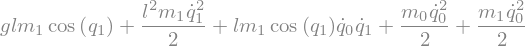

In [11]:
Lag_simp = Lagrangian(N_in, cart_part, pend_part)
Lag_simp

In [12]:
u0, u1 = symbols('u_0, u_1')
FL = [(P0, u0 * N_in.x)]#, (N1, u1 * N_in.z)]
LM_small = SimpLagrangesMethod(Lag_simp, [q0, q1], forcelist=FL, frame=N_in)

Generating M_inv
simplifying M_inv
simplifying RHS
Model completed


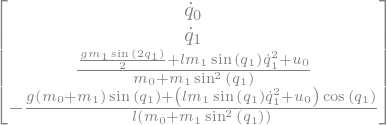

In [13]:
LM_small.form_lagranges_equations()
RHS_small = LM_small.rhs
RHS_small

In [14]:
num_pinv_dyn = LM_small.num_pinv_dyn([u0,])

### Casadi optimization

In [15]:
m0_n, m1_n = [1., 0.3]
l_n = 0.5
g_n = 9.81
params = [g_n, l_n, m0_n, m1_n]

In [16]:
import casadi as cas
from optibot.casadi import rhs_to_casadi_function, restriction2casadi, sympy2casadi
from optibot.schemes import euler_restr, trapz_restr, trapz_mod_restr, hs_mod_restr, hs_restr, hs_mod_restr, hs_parab_restr, hs_mod_parab_restr

In [17]:
from optibot.symbolic import find_arguments

In [18]:
F_cas_x = rhs_to_casadi_function(RHS_small, 2, mode = 'x', verbose=False, silent=True)

In [20]:

F_cas = rhs_to_casadi_function(RHS_small[2:], 2, mode = 'q', verbose=False, silent= True)

In [21]:
x_sym = cas.SX.sym('x', 4)
x_dot_sym = cas.SX.sym('x_dot', 4)
u_sym = cas.SX.sym('u',1)
p_sym = cas.SX.sym('p',4)

dynam_f_x = cas.Function(
    "dynamics_x",
    [x_sym, x_dot_sym, u_sym, p_sym],
    [x_dot_sym[2:].T - F_cas(x_sym[:2], x_sym[2:], u_sym, p_sym)]
)

In [22]:
q_sym = cas.SX.sym('q', 2)
q_dot_sym = cas.SX.sym('q_dot', 2)
q_dot_dot_sym = cas.SX.sym('q_dot_dot', 2)
u_sym = cas.SX.sym('u',1)

dynam_f_q = cas.Function(
    "dynamics_q",
    [q_sym, q_dot_sym, q_dot_dot_sym, u_sym, p_sym],
    [q_dot_dot_sym.T - F_cas(q_sym, q_dot_sym, u_sym, p_sym)]
)

from optibot.opti import _get_f_g_funcs
_, dynam_f_x, dynam_f_q = _get_f_g_funcs(RHS_small, 2, silent = False)

In [23]:
def gen_ini_guess(N = 25, ini_guess = 'zero'):
    if ini_guess == 'zero':
        x_init_guess = np.zeros([N,4])
    elif ini_guess == 'lin':
        def_q1 = np.linspace(0,1,N)
        def_q2 = np.linspace(0,np.pi,N)
        def_v1 = np.zeros(N)
        def_v2 = np.zeros(N)
        x_init_guess = np.array([def_q1, def_q2, def_v1, def_v2]).T
    elif ini_guess == 'funcs':
        def_t = np.linspace(0,2,N)
        def_q1 = (0.8*np.arctan(def_t*3))**2
        def_q2 = -np.sin(3*def_t**0.8)*def_t*2
        def_v1 = np.sin(5*def_t)/(def_t+0.2)
        def_v2 = -3*np.sin(5*def_t**0.8)*(4*def_t - 2*def_t**2)
        x_init_guess = np.array([def_q1, def_q2, def_v1, def_v2]).T
    return x_init_guess

def sol_value(u_arr):
    N = len(u_arr)
    return(np.sum(u_arr[:]**2)+np.sum(u_arr[1:-1]**2))/N

In [24]:
def rand_array(shape, central, deviation):
    central = np.array(central)
    deviation = np.array(deviation)
    x = 2*(np.random.rand(*shape)-0.5)
    x = deviation * x
    x = central + x
    return x

In [25]:
import time
def chrono_solve(opti, solve_repetitions):
    cput0 = time.time()
    for ii in range(solve_repetitions):
        sol = opti.solve()
    cput1 = time.time()
    cpudt = (cput1-cput0)/solve_repetitions
    return sol, cpudt


def chrono_solve_random_init(opti, solve_repetitions, u_opti, u_lim, x_opti, x_0, x_f, cost):
    cpudt = 0.
    err_count = 0
    mean_cost = 0.
    if not (type(u_lim) == int or type(u_lim) == float):
        u_lim = opti.value(u_lim)
    if type(x_0) == cas.MX:
        x_0 = opti.value(x_0)
    if type(x_f) == cas.MX:
        x_f = opti.value(x_f)
    x_0 = np.array(x_0)
    x_f = np.array(x_f)
        
        
    for ii in range(solve_repetitions):
        unresolved = True
        while unresolved:
            try:
                rnd_u = rand_array(u_opti.shape, 0, u_lim)
                x_dev = 2*(x_f-x_0)
                dim = x_dev.shape[0]//2
                x_dev[dim:] += 10 * x_dev[:dim]
                rnd_x = rand_array(x_opti.shape, (x_0+x_f)/2, x_dev)
                opti.set_initial(u_opti, rnd_u)
                opti.set_initial(x_opti, rnd_x)
                cput0 = time.time()
                sol = opti.solve()
                cput1 = time.time()
            except RuntimeError:
                print('*', end='')
                err_count += 1
            else:
                unresolved = False
                print('.', end='')
        cpudt += (cput1-cput0)
        mean_cost += sol.value(cost)
    cpudt = cpudt/solve_repetitions
    mean_cost = mean_cost/solve_repetitions
    return sol, cpudt, err_count/solve_repetitions, mean_cost

## Pruebas de Funciones Objetivo

from optibot.pseudospectral import LGL, LG
from sympy import integrate, Abs, lambdify, Matrix
from optibot.casadi import sympy2casadi

x = symbols('x')
@lru_cache
def obj_f_u_LGL_cas(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LGL(N, precission), coefs)
    res = integrate((pol_lag)**2, [x, -1, 1])
    mm = Matrix(coefs)
    c_cas = cas.SX.sym('coefs', N)
    res_cas = sympy2casadi(res, coefs, cas.vertsplit(c_cas))

    f_cas = cas.Function(
        "integral_func",
        [c_cas],
        [res_cas]
    )
    return f_cas

@lru_cache
def obj_f_u_LG2_cas(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LG(N, precission), coefs)
    res = integrate((pol_lag)**2, [x, -1, 1])
    mm = Matrix(coefs)
    c_cas = cas.SX.sym('coefs', N)
    res_cas = sympy2casadi(res, coefs, cas.vertsplit(c_cas))

    f_cas = cas.Function(
        "integral_func",
        [c_cas],
        [res_cas]
    )
    return f_cas


def sum_terms(iterable):
    res = iterable[0]
    for term in iterable[1:]:
        res = res + term
    return res

_list_pol = [_lp.subs(x, ii)**2 for ii in np.linspace(-1, 1, 100)]
_integ = sum_terms(_list_pol) + sum_terms(_list_pol[1:-1])

_opt_1 = simplify(_integ)/100

_opt_2 = integrate((_lp)**2, [x, -1, 1])

_opt_1

_opt_2

_simb_pl = lagrangePolynomial(symbols(f'p_0:{3}'),symbols(f'c_0:{3}'))

_simb_integ = integrate((_simb_pl)**2, [x, -1, 1])

_N = 3
_lp = lagrangePolynomial(LG(_N), symbols(f'c_0:{_N}'))
integrate((_lp)**2, [x, -1, 1])

from optibot.pseudospectral import lag_pol
from sympy import expand

integrate(expand(lag_pol(symbols(f'p_0:{3}'), 0) * lag_pol(symbols(f'p_0:{3}'), 1)), [x, -1, 1]).simplify()

_N = 5
_tau = tuple(LGL(_N))
integrate(expand(lag_pol(_tau, 2) * lag_pol(_tau, 1)), [x, -1, 1]).simplify()

_N = 5
_tau = tuple(LG(_N))
integrate(expand(lag_pol(_tau, 2)**2), [x, -1, 1]).simplify()

from optibot.pseudospectral import _v_sum
def bary_sym_comp(t_arr, y_arr):
    t = symbols("t")
    n = len(t_arr)
    v_arr = [_v_sum(t_arr, ii) for ii in range(n)]
    sup = 0
    for i in range(n):
        sup += v_arr[i] * y_arr[i] / (t - t_arr[i])
    inf = 0
    for i in range(n):
        inf += v_arr[i] / (t - t_arr[i])
    return sup/inf

_N = 4
_bary_comp_pol = bary_sym_comp(LG(_N),symbols(f'c_0:{_N}'))

(_bary_comp_pol**2)

integrate((_bary_comp_pol**2).simplify(), [t, -1, 1])#.simplify()

def obj_f_u_LGL_cas_comp_bar(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    
    _bary_comp_pol = bary_sym_comp(LGL(N),coefs)
    res = integrate((_bary_comp_pol**2).simplify(), [t, -1, 1]).simplify()
    
    c_cas = cas.SX.sym('coefs', N)
    res_cas = sympy2casadi(res, coefs, cas.vertsplit(c_cas))

    f_cas = cas.Function(
        "integral_func",
        [c_cas],
        [res_cas]
    )
    return f_cas

obj_f_u_LGL_cas_comp_bar(4)

from optibot.pseudospectral import v_coef_coll
@lru_cache(maxsize=None)
def bary_poly_lagr(scheme, N, i):
    """
    Generates a numeric function of t using the barycentric formula

    Parameters
    ----------
    
    Returns
    -------
    polynomial : Function F(t)
        polynomial numerical function

    """
    
    v_arr = [v_coef_coll(N, ii, scheme) for ii in range(N)]
    t_arr = coll_points(N, scheme)
    def lagpol(t):
        def new_poly(t):
            t = np.array(t, dtype="float64")
            sup = v_arr[i] / (t - t_arr[i])
            inf = 0
            for jj in range(N):
                inf += v_arr[jj] / (t - t_arr[jj])
            return sup/inf

        cond_list = [t == t_i for t_i in t_arr]
        func_list = list(np.zeros(N))
        func_list[i] = 1
        func_list.append(new_poly)
        return np.piecewise(t, cond_list, func_list)
    return lagpol

_bar_pol_3_1 = bary_poly_lagr('LG', 3,1)

scheme = 'LG'
_N = 6

_t_arr = np.linspace(-1, 1, 1000)

plt.figure(figsize=[15,10])
for ii in range(_N):
    _bar_pol_lag = bary_poly_lagr(scheme, _N,ii)
    plt.plot(_t_arr, _bar_pol_lag(_t_arr))
plt.vlines(np.array(coll_points(_N, scheme), dtype="float64"), -1,1, colors = 'k', linestyles=':')
plt.grid()

from scipy.integrate import quad

@lru_cache(maxsize=None)
def sci_int_L_sq(scheme, N, i):
    poly = bary_poly_lagr(scheme, N, i)
    def dummy(t):
        return poly(t)**2
    return quad(dummy, -1,1)[0]

@lru_cache(maxsize=None)
def sci_int_L_prod(scheme, N, i, j):
    poly = bary_poly_lagr(scheme, N, i)
    poly_2 = bary_poly_lagr(scheme, N, j)
    def dummy(t):
        return poly(t)*poly_2(t)
    return quad(dummy, -1,1)[0]

def sci_int_L_prod_trapz(scheme, N, i, j, n_interp = 4000):
    poly = bary_poly_lagr(scheme, N, i)
    poly_2 = bary_poly_lagr(scheme, N, j)
    def dummy(t):
        return poly(t)*poly_2(t)
    t_arr = np.linspace(-1,1,n_interp)
    res = np.trapz(dummy(t_arr), t_arr)
    return res

@lru_cache(maxsize=None)
def int_L_sq_LG(N, i):
    _tau = tuple(LG(N))
    return integrate(expand(lag_pol(_tau, i)**2), [x, -1, 1]).simplify()

@lru_cache(maxsize=None)
def int_L_sq_LGL(N, i):
    _tau = tuple(LGL(N))
    return integrate(expand(lag_pol(_tau, i)**2), [x, -1, 1]).simplify()

@lru_cache(maxsize=None)
def int_L_prod_LGL(N, i, j):
    _tau = tuple(LGL(N))
    return integrate(expand(lag_pol(_tau, i) * lag_pol(_tau, j)), [x, -1, 1]).simplify()

%%timeit
int_L_prod_LGL(7, 2, 1)

%%timeit
sci_int_L_prod_trapz('LG', 7, 2, 1)

%%timeit
sci_int_L_prod('LG', 7, 2, 1)

%%timeit
bary_poly_lagr(scheme, 7, 1)

def _poly_prod(scheme, N, i, j):
    poly = bary_poly_lagr(scheme, N, i)
    poly_2 = bary_poly_lagr(scheme, N, j)
    def dummy(t):
        return poly(t)*poly_2(t)
    return dummy

%%timeit
_poly_prod(scheme, 7, 1, 2)

_pol_prod_ej =_poly_prod(scheme, 7, 1, 2)

%%timeit
_pol_prod_ej(_t_arr)

In [ ]:
@lru_cache
def obj_f_u_LGL_cas_alt(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    
    res = 0
    for ii in range(N):
        res = res + coefs[ii]**2 * int_L_sq_LGL(N, ii)
    for jj in range(N):
        for ii in range(jj):
            res = res + 2 * coefs[jj] * coefs[ii] * int_L_prod_LGL(N, ii, jj)
    
    c_cas = cas.SX.sym('coefs', N)
    res_cas = sympy2casadi(res, coefs, cas.vertsplit(c_cas))

    f_cas = cas.Function(
        "integral_func",
        [c_cas],
        [res_cas]
    )
    return f_cas


@lru_cache
def obj_f_u_LG_cas_alt(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    
    res = 0
    for ii in range(N):
        res = res + coefs[ii]**2 * int_L_sq_LG(N, ii)
    
    
    c_cas = cas.SX.sym('coefs', N)
    res_cas = sympy2casadi(res, coefs, cas.vertsplit(c_cas))

    f_cas = cas.Function(
        "integral_func",
        [c_cas],
        [res_cas]
    )
    return f_cas


@lru_cache
def obj_f_u_cas_sci(N, scheme, precission = 20):
    
    if scheme == 'LG2':
        return obj_f_u_cas_sci(N, 'LG', precission)
    elif scheme == 'D2':
        return obj_f_u_cas_sci(N, 'LGL', precission)
    
    coefs = symbols(f'c_0:{N}')
    
    res = 0
    for ii in range(N):
        res = res + coefs[ii]**2 * sci_int_L_sq(scheme, N, ii)
    if scheme not in ['LG', 'LG2']:
        for jj in range(N):
            for ii in range(jj):
                res = res + 2 * coefs[jj] * coefs[ii] * sci_int_L_prod(scheme, N, ii, jj)
    
    c_cas = cas.SX.sym('coefs', N)
    res_cas = sympy2casadi(res, coefs, cas.vertsplit(c_cas))

    f_cas = cas.Function(
        "integral_func",
        [c_cas],
        [res_cas]
    )
    return f_cas

In [ ]:
_N = 5


_ff_old = obj_f_u_LGL_cas(_N)
_ff_comp_bar = obj_f_u_cas_sci(_N,'LGL')

In [ ]:
_test_data = [7,9,3,4,5]
_ff_old(_test_data),_ff_comp_bar(_test_data)

In [ ]:
_t_0 = time.time()
_res_1 = obj_f_u_LG2_cas(8)
print(time.time()-_t_0)

In [ ]:
_t_0 = time.time()
_res_2 = obj_f_u_LG_cas_alt(8)
print(time.time()-_t_0)

In [ ]:
_t_0 = time.time()
_res_2 = obj_f_u_cas_sci(8, 'LG')
print(time.time()-_t_0)

In [ ]:
_t_0 = time.time()
obj_f_u_LGL_cas(8)
print(time.time()-_t_0)

In [ ]:
_t_0 = time.time()
obj_f_u_LGL_cas_alt(8)
print(time.time()-_t_0)

In [ ]:
_t_0 = time.time()
_res_2 = obj_f_u_cas_sci(8, 'LGL')
print(time.time()-_t_0)

## Bloque Opti

In [52]:
from optibot.pseudospectral import get_bary_extreme_f
def get_cost_obj_trap_int(scheme, N):
    t_arr = [-1,] + coll_points(N, scheme) + [1,]
    t_arr = [float(ii) for ii in t_arr]
    start_p_f = get_bary_extreme_f(scheme, N, mode = 'u', point = 'start')
    end_p_f = get_bary_extreme_f(scheme, N, mode = 'u', point = 'end')
    def obj_f(coefs):
        start_p = start_p_f(coefs)
        end_p = end_p_f(coefs)
        coef_list = [start_p] + [coefs[jj] for jj in range(N)] + [end_p]
        sum_res = 0
        for jj in range(N+1):
            sum_res += (coef_list[jj]**2+coef_list[jj+1]**2)*(t_arr[jj+1]-t_arr[jj])/2            
        return sum_res
    return obj_f

def get_cost_obj_trap_int_cas(scheme, N):
    u_sym = cas.SX.sym('u',N)
    u_sympy = symbols(f'c0:{N}')
    fun = get_cost_obj_trap_int(scheme, N)
    sympy_expr = fun(u_sympy)
    cas_expr = sympy2casadi(sympy_expr, u_sympy, cas.vertsplit(u_sym))
    cas_f = cas.Function(
        "cost_func",
        [u_sym,],
        [cas_expr,]
    )
    return cas_f

In [53]:
def LG_end_p_fun_cas(N, precission=20):
    from casadi import SX, vertsplit, Function
    from optibot.casadi import sympy2casadi
    x_cas = cas.SX.sym('x',N)
    x_sympy = symbols(f'c0:{N}')
    fun = get_bary_extreme_f('LG', N, mode = 'x', point = 'end')
    sympy_expr = fun(x_sympy)
    cas_expr = sympy2casadi(sympy_expr, x_sympy, cas.vertsplit(x_cas))
    cas_f = cas.Function(
        "dynamics_q",
        [x_cas,],
        [cas_expr,]
    )
    return cas_f

In [54]:
def opti_setup(col_points = 7, scheme = 'LGL', precission = 20, M = 1, U_dim = 1):
    opti = cas.Opti()
    opts = {'ipopt.print_level':0, 'print_time':0}
    opti.solver('ipopt', opts)
    
    opt_dict = {
        'LGL': [col_points,],
        'D2': [col_points,],
        'LG2': [col_points+2,],
        'LGLm': [col_points+2,],
        'LG': [col_points+1,]
    }
    sch_options = opt_dict[scheme]
    N = sch_options[0]
    
    if scheme in ['LGL','LG']:
        x_opti = opti.variable(N, 2*M)
    elif scheme in ['LG2', 'D2', 'LGLm']:
        x_opti = opti.variable(N, M)
    else:
        raise ValueError('Unsupported scheme')
    
    u_opti = opti.variable(col_points, U_dim)
    tau_arr = base_points(N, scheme, precission)
    return opti, N, x_opti, u_opti, tau_arr

def opti_start_point_constr(opti, scheme, x_opti, x_dot_opti, x_s, M=1):
    if scheme == 'LGL':
        opti.subject_to(x_opti[0,:].T == x_s)
    elif scheme == 'LG':
        opti.subject_to(x_opti[0,:].T == x_s)
    elif scheme == 'D2':
        opti.subject_to(x_opti[0,:].T == x_s[:M])
        opti.subject_to(x_dot_opti[0,:].T == x_s[M:])
    elif scheme == 'LG2':
        opti.subject_to(x_opti[0,:].T == x_s[:M])
        opti.subject_to(x_dot_opti[0,:].T == x_s[M:])
    elif scheme == 'LGLm':
        opti.subject_to(x_opti[0,:].T == x_s[:M])
        opti.subject_to(x_dot_opti[0,:].T == x_s[M:])
        
def opti_end_point_constr(opti, scheme, x_opti, x_dot_opti, N, x_f, precission = 20, M=1):
    if scheme == 'LGL':
        opti.subject_to(x_opti[-1,:].T == x_f)
    elif scheme == 'LG':
        endp_f = LG_end_p_fun_cas(N, precission)
        for ii in range(2*M):
            opti.subject_to(endp_f(x_opti[:,ii]) == x_f[ii])
    elif scheme == 'D2':
        opti.subject_to(x_opti[-1,:].T == x_f[:M])
        opti.subject_to(x_dot_opti[-1,:].T == x_f[M:])
    elif scheme == 'LG2':
        opti.subject_to(x_opti[-1,:].T == x_f[:M])
        opti.subject_to(x_dot_opti[-1,:].T == x_f[M:])
    elif scheme == 'LGLm':
        opti.subject_to(x_opti[-1,:].T == x_f[:M])
        opti.subject_to(x_dot_opti[-1,:].T == x_f[M:])
        
def opti_col_point_constr(opti, scheme, x_opti, x_dot_opti, x_dot_dot_opti, u_opti, params,
                          dynam_f_x, dynam_f_q, N, M=1):
    if scheme == 'LGL':
        for ii in range(N):
            opti.subject_to(dynam_f_x(x_opti[ii,:], x_dot_opti[ii,:], u_opti[ii,:], params)==0)
            opti.subject_to(x_opti[ii,M:] == x_dot_opti[ii,:M]) 
    if scheme == 'LG':
        #opti.subject_to(x_opti[0,1] == x_dot_opti[0,0]) #convert starting into semicollocation point
        for ii in range(1, N):
            opti.subject_to(dynam_f_x(x_opti[ii,:], x_dot_opti[ii,:], u_opti[ii-1,:], params)==0)
            opti.subject_to(x_opti[ii,M:] == x_dot_opti[ii,:M])
    elif scheme == 'D2':
        for ii in range(N):
            opti.subject_to(dynam_f_q(x_opti[ii,:], x_dot_opti[ii,:], x_dot_dot_opti[ii,:], u_opti[ii,:], params)==0)
    elif scheme == 'LG2':
        for ii in range(1, N-1):
            opti.subject_to(dynam_f_q(x_opti[ii,:], x_dot_opti[ii,:], x_dot_dot_opti[ii,:], u_opti[ii-1,:], params)==0)
    elif scheme == 'LGLm':
        for ii in range(1, N-1):
            opti.subject_to(dynam_f_q(x_opti[ii,:], x_dot_opti[ii,:], x_dot_dot_opti[ii,:], u_opti[ii-1,:], params)==0)
    

def opti_read_sol_arrays(scheme, sol, x_opti, u_opti, D_mat, t_f, t_0, M):
    xx_sol = sol.value(x_opti)
    uu_sol = sol.value(u_opti)
    D_mat = np.array(D_mat)
    if scheme == 'LGL':
        qq_sol = xx_sol[:,:M]
        vv_sol = xx_sol[:,M:]
    elif scheme == 'LG':
        qq_sol = xx_sol[:,:M]
        vv_sol = xx_sol[:,M:]
    elif scheme == 'D2':
        qq_sol = xx_sol
        vv_sol = 2/(t_f - t_0) * D_mat@qq_sol
    elif scheme == 'LG2':
        qq_sol = xx_sol
        vv_sol = 2/(t_f - t_0) * D_mat@qq_sol
    elif scheme == 'LGLm':
        qq_sol = xx_sol
        vv_sol = 2/(t_f - t_0) * D_mat@qq_sol
    return qq_sol, vv_sol, uu_sol

In [55]:
#@lru_cache
def casadi_cartpole_pssp(col_points = 7, scheme = 'LG', ini_guess = 'zero', 
                         solve_repetitions = 1, t_end = 2, precission = 20):
    
    if scheme not in ['LG', 'LGL', 'D2', 'LG2', 'LGLm']:
        raise ValueError(f'Unrecognized scheme: {scheme}')
        
    opti, N, X, U, tau_arr = opti_setup(col_points, scheme, precission, M=2)

    t_0 = 0
    u_m = opti.parameter()
    Params = opti.parameter(4)
    
    D_mat = sympy2casadi(matrix_D_bary(N, scheme,precission), [], [])
    x_dot_opti = 2/(t_end - t_0) * D_mat@X
    x_dot_dot_opti = 2/(t_end - t_0) * D_mat@x_dot_opti
    
    
    #   PONER LA EXPRESIÓN BUENA LUEGO
    
    #cost = (cas.sum1(U[:]**2)+cas.sum1(U[1:-1]**2))/N
    #cost = cas.sum1(cas.cos(X[:,1]))
    #cost = T
    #f_cost = obj_f_u_cas_sci(N, scheme)
    #cost = f_cost(U)
    
    #col_p_t = np.array(coll_points(col_points, scheme), dtype = 'float')
    #us = U**2
    #cost = us[0] + 0.5 * (us[0]*col_p_t[0] + cas.sum1(us[:-1]*col_p_t[1:])- cas.sum1(us[1:]*col_p_t[:-1]) -us[-1]*col_p_t[-1]) + us[-1]
    #cost = cas.sum1(us)/N
    f_u_cost = get_cost_obj_trap_int_cas(scheme, col_points)
    cost = f_u_cost(U)
    #print('cost = ', f_u_cost(cas.SX.sym('u',col_points)))
    opti.minimize(cost)
    
    
    #opti.subject_to(X[0,:].T == [0,0,0,0])
    
    #print(X.shape)
    opti_start_point_constr(opti, scheme, X, x_dot_opti, x_s = [0,0,0,0], M=2)
    opti_end_point_constr(opti, scheme, X, x_dot_opti, N, x_f = [1, np.pi, 0, 0], M=2)
    opti_col_point_constr(opti, scheme, X, x_dot_opti, x_dot_dot_opti, U, Params,
                          dynam_f_x, dynam_f_q, N, M=2)
    

    #opti.subject_to(opti.bounded(-u_m,U[:, :],u_m))
    max_f = 20.0
    opti.set_value(u_m, max_f)

    m0_n, m1_n = [1., 0.3]
    l_n = 0.5
    g_n = 9.81
    opti.set_value(Params, [g_n, l_n, m0_n, m1_n])
    
    if ini_guess in ['zero', 'lin', 'funcs']:
        x_ini_guess = gen_ini_guess(N, ini_guess)
        if scheme in ['LG', 'LGL']:
            opti.set_initial(X, x_ini_guess)
        elif scheme in ['D2', 'LG2', 'LGLm']:
            opti.set_initial(X, x_ini_guess[:,:2])
        else:
            raise ValueError
    elif type(ini_guess) == list:
        opti.set_initial(X, ini_guess[0])
        opti.set_initial(U, ini_guess[1])
    elif ini_guess == 'random':
        pass
    else:
        raise TypeError('initial guess not understood')
    if ini_guess == 'lin':
        #Ensuring solution corresponds to kellys minimum
        #opti.subject_to(X[:2,0]>= 0)
        pass
            
    #return opti
    
    if ini_guess == 'random':
        sol, cpudt, err_count, sol_cost = chrono_solve_random_init(
            opti,
            solve_repetitions,
            U,
            u_m,
            X,
            0,
            [1, np.pi, 0, 0],
            cost)
    else:
        sol, cpudt = chrono_solve(opti, solve_repetitions)
        err_count = None
        sol_cost = sol.value(cost)
    qq_sol, vv_sol, uu_sol = opti_read_sol_arrays(scheme, sol, X, U, D_mat, t_end, t_0, 2)
    return qq_sol, vv_sol, uu_sol, cpudt, err_count, sol_cost

In [59]:
schemes = ['LG','LG2']#'D2', 'LGL', 
initials = ['lin']#, 'funcs']
solve_repetitions = 1
N_arr = [4,5,6,7,8,9,10,11,12]#,13,14,15,16,17,18,19,20,21,22,23,24,25,30,35,40,45,50]#
results = {}

for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        print('Problem:', key)
        results[key] = {'N_arr':N_arr}
        for N in N_arr:
            print(f'\tN = {N} , ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
            qq, vv, uu, cpudt, err_count, cost = casadi_cartpole_pssp(N, scheme, init, solve_repetitions)
            results[key][N] = {
                'q': qq,
                'v': vv,
                'u': uu,
                'cpudt': cpudt,
                'cost': cost
            }



Problem: LG_lin
	N = 4 ,  14:17:25 
	N = 5 ,  14:17:25 
	N = 6 ,  14:17:25 
	N = 7 ,  14:17:25 
	N = 8 ,  14:17:25 
	N = 9 ,  14:17:25 
	N = 10 ,  14:17:25 
	N = 11 ,  14:17:26 
	N = 12 ,  14:17:26 
Problem: LG2_lin
	N = 4 ,  14:17:26 
	N = 5 ,  14:17:26 
	N = 6 ,  14:17:26 
	N = 7 ,  14:17:26 
	N = 8 ,  14:17:26 
	N = 9 ,  14:17:26 
	N = 10 ,  14:17:26 
	N = 11 ,  14:17:26 
	N = 12 ,  14:17:27 


In [60]:
for scheme in schemes:
    key = scheme + '_lin'
    _c = []
    _cpudt = []
    for N in results[key]['N_arr']:
        _c.append(results[key][N]['cost'])
        _cpudt.append(results[key][N]['cpudt'])
    results[key]['cost'] = np.array(_c)
    results[key]['cpudt'] = np.array(_cpudt)


In [61]:
plt.rcParams.update({'font.size': 15})
oct_fig_size = [10,6]
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

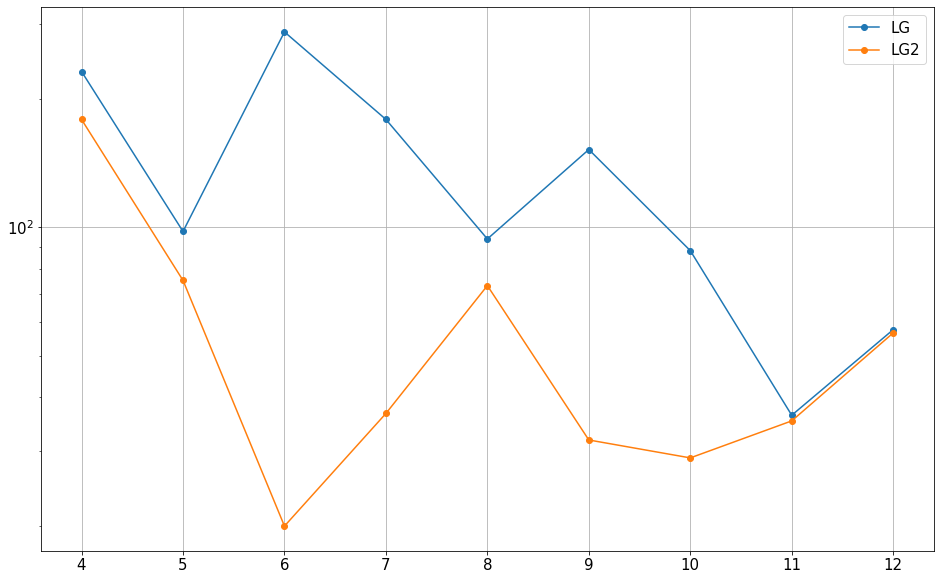

In [62]:

plt.figure(figsize=[16,10])
for scheme in schemes:
    key = scheme + '_lin'
    plt.plot(results[key]['N_arr'], results[key]['cost'][:], marker = 'o', label = scheme)
plt.yscale('log')
plt.grid()
plt.legend()

In [65]:
for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        print(key, results[key][10]['cost'])

LG_lin 88.23359807759196
LG2_lin 28.84185647132524


In [67]:
goal = np.mean([results[scheme+'_lin'][10]['cost'] for scheme in schemes])


plt.figure(figsize=[16,10])
for scheme in schemes:
    key = scheme + '_lin'
    plt.plot(results[key]['N_arr'], np.abs(results[key]['cost'][:]-goal), marker = 'o', label = scheme)
plt.yscale('log')
plt.grid()
plt.legend()

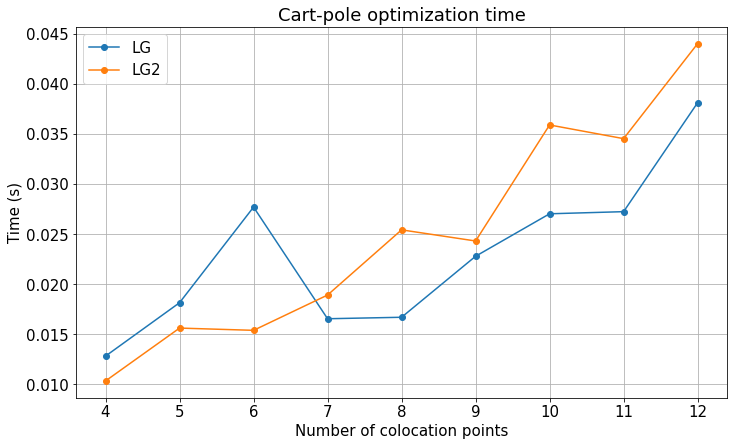

In [68]:

titles = ['LG','LG2']#D2', 'LGL', 
plt.figure(figsize=oct_fig_size)
for ii in range(len(schemes)):
    key = schemes[ii] + '_lin'
    plt.plot(results[key]['N_arr'], results[key][f'cpudt'], marker = 'o', c = f'C{ii}',label = titles[ii])
plt.grid()
plt.legend()
#plt.yscale('log')
plt.title('Cart-pole optimization time')
plt.xlabel('Number of colocation points')
plt.ylabel('Time (s)')
plt.tight_layout(pad = 0.0)
#plt.savefig(r'LG2pics/Cartpole_optimization_time_vs_interval_number.pdf', format='pdf')

## Solución de Hermite Simpson

In [69]:
F_cas_simp = rhs_to_casadi_function(RHS_small[2:], 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



In [70]:
from optibot.numpy import RHS2numpy

In [71]:
def casadi_cartpole_hs(N = 50, scheme = 'hs_parab', ini_guess = 'lin', solve_repetitions = 1, t_end = 2):
    opti = cas.Opti()
    p_opts = {"expand":True,'ipopt.print_level':0, 'print_time':0}
    s_opts = {"max_iter": 10000, 'tol': 1e-26}#, 'linear_solver' : "MA27"}
    opti.solver("ipopt",p_opts,
                        s_opts)
    restr_schemes = {
        'euler': euler_restr,
        'trapz': trapz_restr,
        'trapz_mod' : trapz_mod_restr,
        'hs': hs_restr,
        'hs_mod': hs_mod_restr,
        'hs_parab': hs_parab_restr,
        'hs_mod_parab': hs_mod_parab_restr
    }
    
    f_restr = restr_schemes[scheme]
    if scheme in ['hs_parab', 'hs_mod_parab']:
        parab = True
    else:
        parab = False
    X = opti.variable(N+1,4)
    U = opti.variable(N+1)
    if parab:
        U_c = opti.variable(N)
    T = opti.parameter()
    u_m = opti.parameter()
    Params = opti.parameter(4)

    cost = (cas.sum1(U[:]**2)+cas.sum1(U[1:-1]**2))/N
    if parab:
        cost = (4*cas.sum1(U_c[:]**2) + cas.sum1(U[:]**2)+cas.sum1(U[1:-1]**2))/(3*N)
    #cost = cas.sum1(cas.cos(X[:,1]))
    #cost = T
    opti.minimize(cost)

    opti.subject_to(X[0,:].T == [0, 0, 0, 0])
    opti.subject_to(X[-1,:].T == [1, np.pi, 0, 0])
    if parab: 
        restriction = restriction2casadi(f_restr, F_cas_simp, 2, 1, 4, 1)
    else:
        restriction = restriction2casadi(f_restr, F_cas_simp, 2, 1, 4)

    for ii in range(N):
        if parab:
            opti.subject_to(restriction(X[ii,:], X[ii+1,:], U[ii,:], U[ii+1],T/N, Params, U_c[ii])==0)
            opti.subject_to(opti.bounded(-u_m, U_c[ii,:] ,u_m))
        else:
            opti.subject_to(restriction(X[ii,:], X[ii+1,:], U[ii,:], U[ii+1,:],T/N, Params)==0)
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))

    opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))
    opti.set_value(T, t_end)
    max_f = 20.0
    opti.set_value(u_m, max_f)

    m0_n, m1_n = [1., 0.3]
    l_n = 0.5
    g_n = 9.81
    opti.set_value(Params, [g_n, l_n, m0_n, m1_n])
    
    if ini_guess in ['zero', 'lin', 'funcs']:
        opti.set_initial(X, gen_ini_guess(N+1, ini_guess))
    elif type(ini_guess) == list:
        opti.set_initial(X, ini_guess[0])
        opti.set_initial(U, ini_guess[1])
        if parab:
            opti.set_initial(U_c, ini_guess[2])
    elif ini_guess == 'random':
        pass
    else:
        raise TypeError('initial guess not understood')
    if ini_guess == 'lin':
        #Ensuring solution corresponds to kellys minimum
        #opti.subject_to(X[:2,0]>= 0)
        pass
    if ini_guess == 'random':
        sol, cpudt, err_count, sol_cost = chrono_solve_random_init(
            opti,
            solve_repetitions,
            U,
            u_m,
            X,
            0,
            [1, np.pi, 0, 0],
            cost)
    else:
        sol, cpudt = chrono_solve(opti, solve_repetitions)
        err_count = None
        sol_cost = sol.value(cost)
    xx_simp = sol.value(X)
    uu_simp = sol.value(U)
    if parab:
        uu_c = sol.value(U_c)
    else:
        uu_c = None
    return xx_simp, uu_simp, uu_c, cpudt, err_count, sol_cost

In [72]:
xx_hs, uu_hs, uu_c_hs, cpudt_hs, err_count_hs, sol_cost_hs = casadi_cartpole_hs()

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



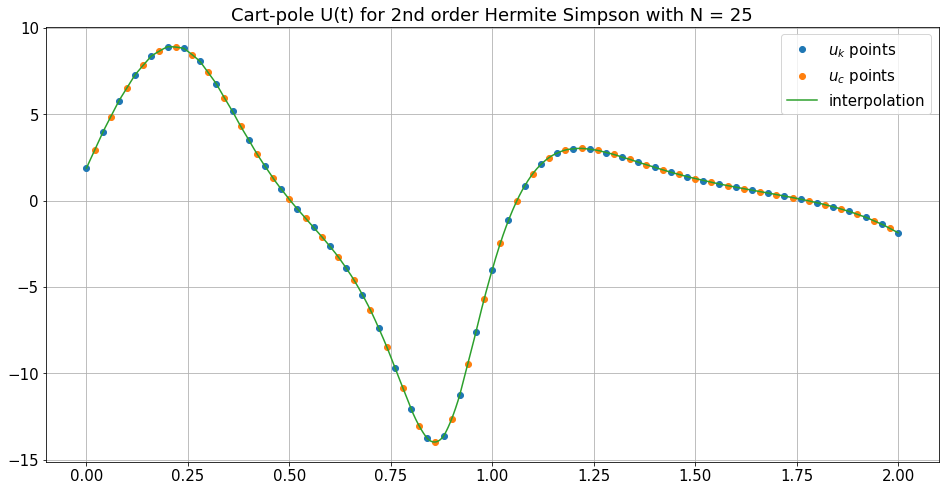

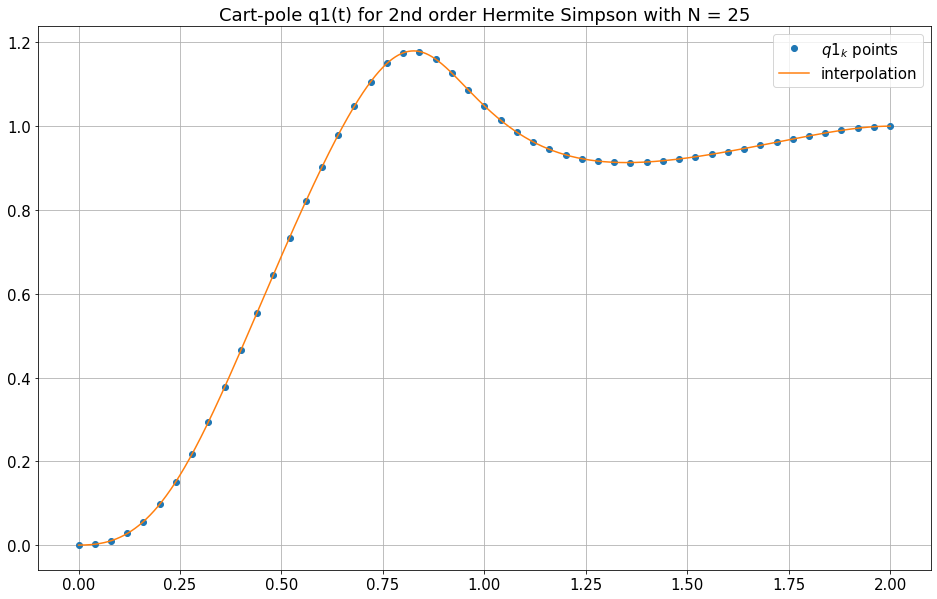

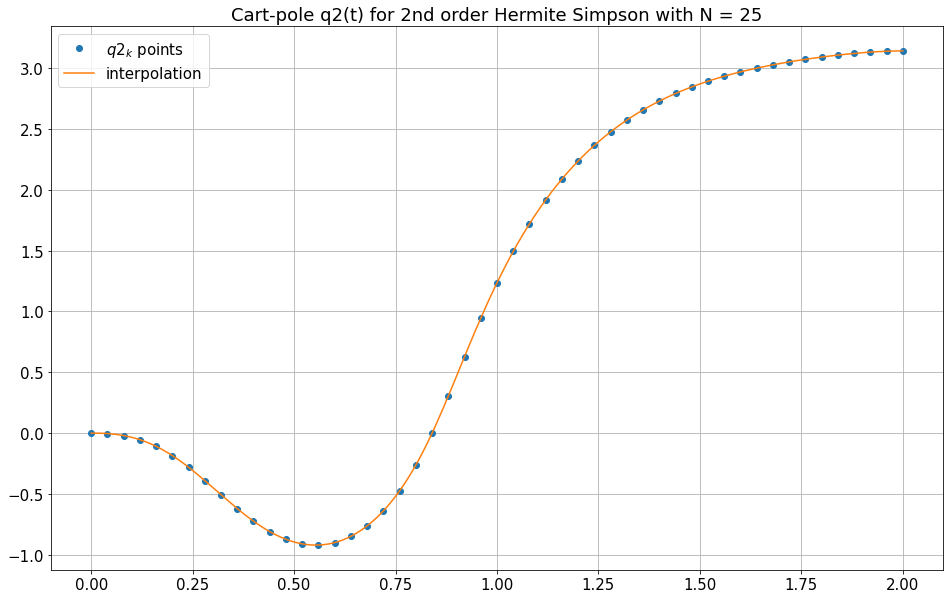

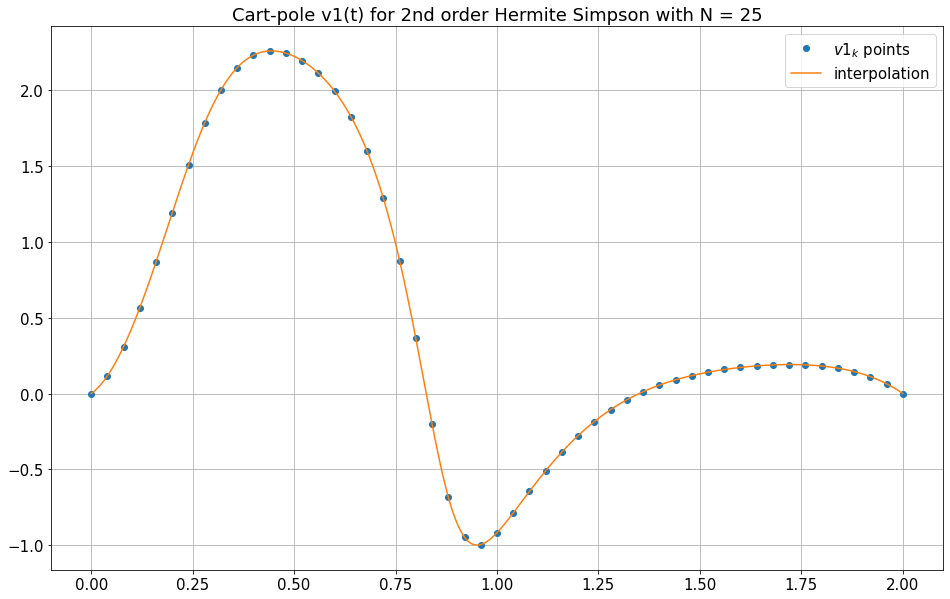

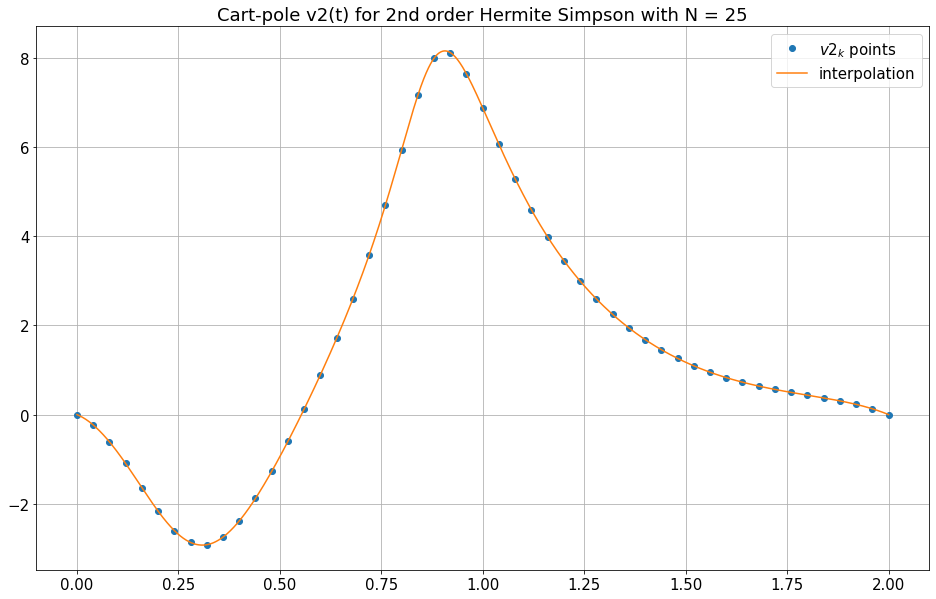

In [73]:
from optibot.schemes import interpolated_array
scheme = 'hs_parab'
N = 50
F_nump_x = RHS2numpy(RHS_small, 2, mode = 'x')
xx_interp_hs, uu_interp_hs = interpolated_array(
    X = xx_hs,
    U = uu_hs,
    F = F_nump_x,
    h = 2/N,
    t_array = np.linspace(0, 2, 2000),
    params = params,
    scheme = "hs_parab",
    u_scheme = 'parab',
    scheme_params = {'u_c' : uu_c_hs}
)
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,2,N+1),uu_hs[:], 'o',label = '$u_k$ points')
plt.plot(np.linspace(0,2,2*N+1)[1::2],uu_c_hs, 'o',label = '$u_c$ points')
plt.plot(np.linspace(0,2,2000),uu_interp_hs, label = 'interpolation')
plt.grid()
plt.legend()
plt.title('Cart-pole U(t) for 2nd order Hermite Simpson with N = 25')
labels = ['q1','q2','v1','v2']
for ii in range(4):
    plt.figure(figsize=[16,10])
    plt.plot(np.linspace(0,2,N+1),xx_hs[:,ii], 'o',label = f'${labels[ii]}_k$ points')
    plt.plot(np.linspace(0,2,2000),xx_interp_hs[:,ii], label = 'interpolation')
    plt.grid()
    plt.legend()
    plt.title(f'Cart-pole {labels[ii]}(t) for 2nd order Hermite Simpson with N = 25')

In [ ]:
for scheme in schemes:
    key = scheme + '_lin'
    for N in results[key]['N_arr']:
        pass
        #print('cost:', results[key][N]['cost'], 'scheme:', scheme, 'N:', N)


In [ ]:
def plot_u(uu, scheme, tf, color = 'k', t0 = 0, N_interp = 300):
    N = len(uu)
    tau = coll_points(N, scheme, 30)
    b_pol = bary_poly(tau, uu)
    coll_p_t = t0 + (1 + np.array(tau))*(tf - t0)/2
    tau_int_arr = np.linspace(-1, 1, N_interp)
    t_int_arr = np.linspace(t0, tf, N_interp)
    
    plt.plot(coll_p_t, uu, color+'o', label = 'control '+scheme)
    
    plt.plot(t_int_arr, b_pol(tau_int_arr), color)

In [ ]:
def plot_x(qq, scheme, tf, color = 'k', t0 = 0, N_interp = 300, label = 'q'):
    N = len(qq)
    #tau = get_taus(N, scheme)
    tau = base_points(N, scheme, 30)
    b_pol = bary_poly(tau, qq)
    coll_p_t = t0 + (1 + np.array(tau))*(tf - t0)/2
    tau_int_arr = np.linspace(-1, 1, N_interp)
    t_int_arr = np.linspace(t0, tf, N_interp)
    
    plt.plot(coll_p_t, qq, color+'o', label = label + ' ' +scheme)
    
    plt.plot(t_int_arr, b_pol(tau_int_arr), color)

In [ ]:
plt.figure(figsize=[16,10])
#for ii in range(4):
ii = 1
N = 45

key = 'LG2_lin'
plot_x(results[key][N]['q'][:,ii], 'LG2', 2, color = 'C0', t0 = 0, N_interp = 300)
#key = 'LGL_lin'
#plot_x(results[key][N]['q'][:,ii], 'LGL', 2, color = 'C1', t0 = 0, N_interp = 300)
plt.grid()
plt.legend()

In [ ]:
plt.figure(figsize=[16,10])
N = 45

key = 'LG_lin'
plot_u(results[key][N]['u'], 'LG', 2, color = 'C0', t0 = 0, N_interp = 300)
#key = 'LGL_lin'
#plot_u(results[key][N]['u'], 'LGL', 2, color = 'C1', t0 = 0, N_interp = 300)
key = 'LG2_lin'
plot_u(results[key][N]['u'], 'LG2', 2, color = 'C3', t0 = 0, N_interp = 300)
plt.grid()
plt.legend()

In [ ]:
plt.figure(figsize=[16,10])
N = 40

key = 'LG_lin'
plot_u(results[key][N]['u'], 'LG', 2, color = 'C0', t0 = 0, N_interp = 300)
#key = 'LGL_lin'
#plot_u(results[key][N]['u'], 'LGL', 2, color = 'C1', t0 = 0, N_interp = 300)
key = 'LG2_lin'
plot_u(results[key][N]['u'], 'LG2', 2, color = 'C3', t0 = 0, N_interp = 300)

plt.plot(np.linspace(0,2,2000),uu_interp_hs, color = 'C4', label = 'control HS')
plt.grid()
plt.legend()

## Errores Dinámicos y análisis

In [ ]:
from optibot.schemes import integrate_hs, integrate_trapz, integrate_euler, integrate_rk4, integrate_hs_mod

In [ ]:
F_nump = RHS2numpy(RHS_small, 2, mode = 'q')

In [ ]:
F_nump([0,0.5],[1,2],[0.5,], params)

#from optibot.schemes import interpolated_array, interpolated_array_derivative
from optibot.pseudospectral import dynamic_error_pseudospectral

In [ ]:
scheme = 'LG'
key = 'LG_lin'

In [ ]:
F_nump(
    results[key][N]['q'][0],
    results[key][N]['v'][0],
    results[key][N]['u'][0],
    params
)

In [ ]:
from optibot.pseudospectral import bary_poly_2d

In [ ]:
from optibot.pseudospectral import get_pol_x, get_pol_u
def get_pols(results, scheme, N, init = 'lin', t0 = 0, t1 = 2):
    key = scheme + '_lin'
    if 'pol_q' not in results[key][N].keys():
        pol_q, pol_v, pol_q_d, pol_v_d, pol_q_d_d = get_pol_x(
            scheme,
            results[key][N]['q'],
            results[key][N]['v'],
            t0, t1)
        pol_u = get_pol_u(scheme, results[key][N]['u'])
        results[key][N]['pol_q'] = pol_q
        results[key][N]['pol_v'] = pol_v
        results[key][N]['pol_q_d'] = pol_q_d
        results[key][N]['pol_v_d'] = pol_v_d
        results[key][N]['pol_q_d_d'] = pol_q_d_d
        results[key][N]['pol_u'] = pol_u
    return (results[key][N]['pol_q'],results[key][N]['pol_v'],results[key][N]['pol_q_d'],
            results[key][N]['pol_v_d'],results[key][N]['pol_q_d_d'],results[key][N]['pol_u'])

In [ ]:
scheme = ['D2', 'LGL', 'LG','LG2'][3]
key = scheme + '_lin'
N = 40

In [ ]:
from optibot.pseudospectral import try_array_f

f_arr = try_array_f(F_nump)
_pols = get_pols(results, scheme, N)
_pol_q, _pol_v, _pol_q_d, _pol_v_d, _pol_q_d_d, _pol_u = _pols
def _f_t(t):
    return f_arr(_pol_q(t), _pol_q_d(t), _pol_u(t),params)

In [ ]:
plt.figure(figsize=[14,10])
_t_arr = np.linspace(-1, 1, 1000)
plt.plot(_t_arr, _pol_q_d_d(_t_arr))
plt.plot(_t_arr, _f_t(_t_arr))
plt.grid()
_tt = np.array(coll_points(N, scheme), dtype = 'float')
plt.plot(_tt, _pol_q_d_d(_tt), 'ok')

In [ ]:
_d_e = dynamic_error_pseudospectral(
    results[key][N]['q'],
    results[key][N]['v'],
    results[key][N]['u'],
    scheme,
    t0 = 0,
    t1 = 2,
    u_interp="pol",
    x_interp="pol",
    g_func=F_nump,
    params=params,
    n_interp = 1000,
)

In [ ]:
for ii in range(3):
    plt.figure(figsize=[14,10])
    plt.plot(np.linspace(-1, 1, 1000), _d_e[ii])
    plt.grid()
    plt.plot(coll_points(N, scheme), np.zeros_like(coll_points(N, scheme)), 'ok')

In [ ]:
from numpy import array, piecewise, linspace, expand_dims
from optibot.pseudospectral import extend_u_array, get_hermite_x
from optibot.pseudospectral import extend_x_arrays
from optibot.schemes import interp_2d
def _interpolations(
    qq,
    vv,
    uu,
    scheme,
    t0,
    t1,
    u_interp="pol",
    x_interp="pol",
    g_func=lambda q, v, u, p: u,
    params=[],
    n_interp=5000,
):
    """
    Generates arrays of equispaced points with values of dynamic error.
    
    If x(t) = [q(t), v(t)], and the physics equation states that x' = F(x, u),
    which is equivalent to [q', v'] = [v , G(q, v, u)] we can define the 
    dynamic errors at a point t as:
        dyn_q_err = q'(t) - v(t)
        dyn_v_err = v'(t) - G(q(t), v(t), u(t))
        dyn_2_err = q''(t) - G(q(t), v(t), u(t))
        
    'x_interp' and 'u_interp' define the way in which we interpolate the values
    of q, v and u between the given points.

    Parameters
    ----------
    qq : Numpy Array, shape = (W, N)
        Values known of q(t)
    vv : Numpy Array, shape = (W, N)
        Values known of v(t)
    uu : Numpy Array, shape = (Y, [Z])
        Values known of x(t)
    scheme : str
        Pseudospectral cheme used in the optimization.
        Acceptable values are:
            'LG'
            'LG_inv'
            'LGR'
            'LGR_inv'
            'LGL'
            'LGLm'
            'LG2'
            'D2'
    t0 : float
        starting time of interval of analysis
    t1 : float
        ending time of interval of analysis
    u_interp :  string, optional
        Model of the interpolation that must be used. The default is "pol".
        Acceptable values are:
            "pol": corresponding polynomial interpolation
            "lin": lineal interpolation
            "smooth": 3d order spline interpolation
    x_interp : string, optional
        Model of the interpolation that must be used. The default is "pol".
        Acceptable values are:
            "pol": corresponding polynomial interpolation
            "lin": lineal interpolation
            "Hermite": Hermite's 3d order spline interpolation
    g_func : Function of (q, v, u, params)
        A function of a dynamic sistem, so that
            q'' = g(q, q', u, params)
    params : list
        Physical problem parameters to be passed to F
    n_interp : int, default 5000
        number of interpolation points

    Raises
    ------
    NameError
        When an unsupported value for scheme, x_interp or u_interp is used.

    Returns
    -------
    err_q : Numpy array, shape = (n_interp, N)
        equispaced values of dynamic error q'(t) - v(t).
    err_v : Numpy array, shape = (n_interp, N)
        equispaced values of dynamic error v'(t) - G(q(t), v(t), u(t)).
    err_2 : Numpy array, shape = (n_interp, N)
        equispaced values of dynamic error q''(t) - G(q(t), q'(t), u(t)).

    """
    from scipy.interpolate import CubicHermiteSpline as hermite
    from numpy import interp, gradient, zeros_like

    scheme_opts = ["LG", "LG_inv", "LGR", "LGR_inv", "LGL", "D2", "LG2", "LGLm"]
    if scheme not in scheme_opts:
        NameError(f"Invalid scheme.\n valid options are {scheme_opts}")

    N = len(qq)
    tau_arr = linspace(-1, 1, n_interp)

    g_func = try_array_f(g_func)

    if u_interp == "pol":
        pol_u = get_pol_u(scheme, uu)
        u_arr = pol_u(tau_arr)
    elif u_interp == "lin":
        tau_u, uu = extend_u_array(uu, scheme, N)
        if len(uu.shape) == 1:
            u_arr = interp(tau_arr, tau_u, uu)
        elif len(uu.shape) == 2:
            u_arr = interp_2d(tau_arr, tau_u, uu)
        else:
            raise ValueError(
                f"U has {len(uu.shape)} dimensions, values accepted are 1 and 2"
            )
    elif u_interp == "smooth":
        tau_u, uu = extend_u_array(uu, scheme, N)
        uu_dot = gradient(uu, tau_u)
        u_arr = hermite(tau_u, uu, uu_dot)(tau_arr)
    else:
        raise NameError(
            'Invalid interpolation method for u.\n valid options are "pol", "lin", "smooth"'
        )

    if x_interp == "pol":
        tau_x = base_points(N, scheme)
        pol_q, pol_v, pol_q_d, pol_v_d, pol_q_d_d = get_pol_x(scheme, qq, vv, t0, t1)
        q_arr = pol_q(tau_arr)
        v_arr = pol_v(tau_arr)
        q_arr_d = pol_q_d(tau_arr)
        v_arr_d = pol_v_d(tau_arr)
        q_arr_d_d = pol_q_d_d(tau_arr)
    elif x_interp == "lin":
        tau_x, qq, vv = extend_x_arrays(qq, vv, scheme)
        if len(qq.shape) == 1:
            q_arr = interp(tau_arr, tau_x, qq)
            v_arr = interp(tau_arr, tau_x, vv)
        elif len(qq.shape) == 2:
            q_arr = interp_2d(tau_arr, tau_x, qq)
            v_arr = interp_2d(tau_arr, tau_x, vv)
        else:
            raise ValueError(
                f"q has {len(qq.shape)} dimensions, values accepted are 1 and 2"
            )
        
        coll_p = t0 + (1 + array(tau_x, dtype="float64")) * (t1 - t0) / 2
        t_arr_lin = linspace(t0, t1, n_interp)
        q_arr_d = find_der_polyline(t_arr_lin, coll_p, qq)
        v_arr_d = find_der_polyline(t_arr_lin, coll_p, vv)
        q_arr_d_d = zeros_like(q_arr)
    elif x_interp == "Hermite":
        tau_x, qq, vv = extend_x_arrays(qq, vv, scheme)
        aa = g_func(qq, vv, uu, params)
        her_q, her_v, her_q_d, her_v_d, her_q_d_d = get_hermite_x(
            qq, vv, aa, tau_x, t0, t1
        )
        t_arr_lin = linspace(t0, t1, n_interp)
        q_arr = her_q(t_arr_lin)
        v_arr = her_v(t_arr_lin)
        q_arr_d = her_q_d(t_arr_lin)
        v_arr_d = her_v_d(t_arr_lin)
        q_arr_d_d = her_q_d_d(t_arr_lin)
    else:
        raise NameError(
            'Invalid interpolation method for x.\n valid options are "pol", "lin", "Hermite"'
        )
    
    return q_arr, q_arr_d, v_arr, v_arr_d, q_arr_d_d

In [ ]:
N =50
scheme = 'LG'
key = 'LG_lin'

In [ ]:
_q_arr, _q_arr_d, _v_arr, _v_arr_d, _q_arr_d_d = _interpolations(
    results[key][N]['q'],
    results[key][N]['v'],
    results[key][N]['u'],
    scheme,
    t0 = 0,
    t1 = 2,
    u_interp="lin",
    x_interp="Hermite",
    g_func=F_nump,
    params=params,
    n_interp = 1000,
)

In [ ]:

for ii in range(2):
#ii = 1

    plt.figure(figsize=[16,10])
    plot_x(results[key][N]['q'][:,ii],scheme, 2, color = 'C0', t0 = 0, N_interp = 300)
    plt.plot(np.linspace(0, 2, 1000), _q_arr[:,ii])
    plt.grid()
    plt.legend()

for ii in range(2):
#ii = 1

    plt.figure(figsize=[16,10])
    plot_x(results[key][N]['v'][:,ii],scheme, 2, color = 'C0', t0 = 0, N_interp = 300)
    plt.plot(np.linspace(0, 2, 1000), _v_arr[:,ii])
    plt.plot(np.linspace(0, 2, 1000), _q_arr_d[:,ii])
    plt.grid()
    plt.legend()

plt.figure(figsize=[14,10])
_n_interp = 8000
_t_arr = np.linspace(-1, 1, _n_interp)
_q_arr, _q_arr_d, _v_arr, _v_arr_d, _q_arr_d_d = _interpolations(
    results[key][N]['q'],
    results[key][N]['v'],
    results[key][N]['u'],
    scheme,
    t0 = 0,
    t1 = 2,
    u_interp="lin",
    x_interp="Hermite",
    g_func=F_nump,
    params=params,
    n_interp = _n_interp,
)
plt.plot(_t_arr, _q_arr_d_d)

_pols = get_pols(results, scheme, N)
_pol_q, _pol_v, _pol_q_d, _pol_v_d, _pol_q_d_d, _pol_u = _pols
plt.plot(_t_arr, f_arr(_pol_q(_t_arr), _pol_q_d(_t_arr), _pol_u(_t_arr),params))

plt.grid()
_tt = np.array(coll_points(N, scheme), dtype = 'float')
plt.plot(_tt, _pol_q_d_d(_tt), 'ok')
plt.xlim([0.99,1.01])

In [ ]:
_d_e_2 = dynamic_error_pseudospectral(
    results[key][N]['q'],
    results[key][N]['v'],
    results[key][N]['u'],
    scheme,
    t0 = 0,
    t1 = 2,
    u_interp="lin",
    x_interp="Hermite",
    g_func=F_nump,
    params=params,
    n_interp = 1000,
)

In [ ]:
for ii in range(3):
    plt.figure(figsize=[14,10])
    plt.plot(np.linspace(-1, 1, 1000), _d_e_2[ii])
    plt.grid()
    plt.plot(coll_points(N, scheme), np.zeros_like(coll_points(N, scheme)), 'ok')

In [ ]:
N= 12
n_interp = 5000
_d_e = dynamic_error_pseudospectral(
    results['LG_lin'][N]['q'],
    results['LG_lin'][N]['v'],
    results['LG_lin'][N]['u'],
    'LG',
    t0 = 0,
    t1 = 2,
    u_interp="pol",
    x_interp="pol",
    g_func=F_nump,
    params=params,
    n_interp = n_interp,
)
_d_e_2 = dynamic_error_pseudospectral(
    results['LG2_lin'][N]['q'],
    results['LG2_lin'][N]['v'],
    results['LG2_lin'][N]['u'],
    'LG2',
    t0 = 0,
    t1 = 2,
    u_interp="pol",
    x_interp="pol",
    g_func=F_nump,
    params=params,
    n_interp = n_interp,
)

titles = [
    r'First order dynamic error $\varepsilon^{[1]}$,'+f' N = {N}',
    r'$\dot{v} - g(q, v, u),$'+f' N = {N}',
    r'Second order dynamic error $\varepsilon^{[2]}$,'+f' N = {N}'
]
filenames = [
    f'first_order_dynamic_error_N_{N}',
    f'v_dot_g_diff_N_{N}',
    f'second_order_dynamic_error_N_{N}'
]
units = [
    ['m/s', 'rad/s'],
    ['m/s^2', 'rad/s^2'],
    ['m/s^2', 'rad/s^2'],
]
for ii in range(3):
    for jj in range(2):
        plt.figure(figsize=oct_fig_size)
        plt.plot(np.linspace(0, 2, n_interp), np.abs(_d_e[ii])[:,jj], c='C0', label = 'LG')
        plt.plot(np.linspace(0, 2, n_interp), np.abs(_d_e_2[ii])[:,jj],c = 'C1', label = 'LG2')
        plt.grid()
        plt.plot(
            1+np.array(coll_points(N, scheme)),
            np.zeros_like(coll_points(N, scheme)),
            'ok')
        plt.legend()

        plt.title(titles[ii] + f', $q_{jj+1}$')
        plt.xlabel('Time(s)')
        plt.ylabel(f'Dynamic error $({units[ii][jj]})$')
        plt.tight_layout(pad = 0.0)
        plt.savefig(r'LG2pics/cartpole_'+filenames[ii]+f'_q_{jj}.pdf', format='pdf')

## Trapz abs err + integr

In [ ]:
n_interp = 2000
for scheme in schemes:
    key = scheme + '_lin'
    print('scheme: ', scheme)
    for N in results[key]['N_arr']:
        print('\t N:', N)
        _dyn_err = dynamic_error_pseudospectral(
            results[key][N]['q'],
            results[key][N]['v'],
            results[key][N]['u'],
            scheme,
            t0 = 0,
            t1 = 2,
            u_interp="pol",
            x_interp="pol",
            g_func=F_nump,
            params=params,
            n_interp = n_interp,
        )
        results[key][N]['err_q_arr'] = _dyn_err[0]
        results[key][N]['err_v_arr'] = _dyn_err[1]
        results[key][N]['err_2_arr'] = _dyn_err[2]

In [ ]:
for scheme in schemes:
    key = scheme + '_lin'
    print('scheme: ', scheme)
    _lis = []
    _lis_q = []
    _lis_v = []
    for N in results[key]['N_arr']:
        #print('\t N:', N)
        integ_err = np.trapz(np.abs(results[key][N]['err_2_arr']), np.linspace(0,2,n_interp), axis = 0)
        integ_err_q = np.trapz(np.abs(results[key][N]['err_q_arr']), np.linspace(0,2,n_interp), axis = 0)
        integ_err_v = np.trapz(np.abs(results[key][N]['err_v_arr']), np.linspace(0,2,n_interp), axis = 0)
        results[key][N]['err_2_abs_integ'] = integ_err
        results[key][N]['err_q_abs_integ'] = integ_err_q
        results[key][N]['err_v_abs_integ'] = integ_err_v
        _lis.append(integ_err)
        _lis_q.append(integ_err_q)
        _lis_v.append(integ_err_v)
    results[key]['err_2_abs_integ'] = np.array(_lis)
    results[key]['err_q_abs_integ'] = np.array(_lis_q)
    results[key]['err_v_abs_integ'] = np.array(_lis_v)

In [ ]:
units = ['m/s', 'rad/s']
for ii in range(2):
    plt.figure(figsize=oct_fig_size)
    for jj in range(len(schemes)):
        scheme = schemes[jj]
        key = scheme + '_lin'
        col = f'C{jj}'
        plt.plot(results[key]['N_arr'], results[key]['err_2_abs_integ'][:,ii], col, marker = 'o', label = scheme)
        #plt.plot(results[key]['N_arr'], results[key]['err_q_abs_integ'][:,ii], col, ls = '--', marker = 'o', label = scheme)
        #plt.plot(results[key]['N_arr'], results[key]['err_v_abs_integ'][:,ii], col, ls = ':', marker = 'o', label = scheme)
    plt.yscale('log')
    plt.grid()
    plt.legend()
    plt.ylim([1e-2, 1e2])
    
    plt.title('Cartpole second order dynamic error $E^{[2]}_{'+f'q_{ii+1}'+'}$')
    plt.xlabel('Number of collocation points')
    plt.ylabel(f'Dynamic error (${units[ii]}$)')
    plt.tight_layout(pad = 0.0)
    plt.savefig(r'LG2pics/carpole_second_order_dynamic_error_vs_interval_number'+f'_q_{ii+1}.pdf', format='pdf')

In [ ]:
units = ['m/s', 'rad/s']
plt.figure(figsize=oct_fig_size)
_diff_err = (results['LG_lin']['err_2_abs_integ']-results['LG2_lin']['err_2_abs_integ'])/results['LG_lin']['err_2_abs_integ']
for ii in range(2):
#for jj in range(len(schemes)):
    scheme = schemes[jj]
    key = scheme + '_lin'
    col = f'C{jj}'
    plt.plot(results[key]['N_arr'], 
              _diff_err[:,ii],
             col, marker = 'o',) #label = scheme)
    #plt.plot(results[key]['N_arr'], results[key]['err_q_abs_integ'][:,ii], col, ls = '--', marker = 'o', label = scheme)
    #plt.plot(results[key]['N_arr'], results[key]['err_v_abs_integ'][:,ii], col, ls = ':', marker = 'o', label = scheme)
#plt.yscale('log')
plt.grid()
plt.legend()
#plt.ylim([1e-2, 1e2])

plt.title('Cartpole second order dynamic error $E^{[2]}_{'+f'q_{ii}'+'}$')
plt.xlabel('Number of collocation points')
plt.ylabel(f'Dynamic error (${units[ii]}$)')
plt.tight_layout(pad = 0.0)
#plt.savefig(r'LG2pics/carpole_second_order_dynamic_error_vs_interval_number'+f'_q_{ii}.pdf', format='pdf')

In [ ]:
np.mean(_diff_err)

## otras interpolaciones

In [ ]:
n_interp = 4000
for scheme in schemes:
    key = scheme + '_lin'
    print('scheme: ', scheme)
    for N in results[key]['N_arr']:
        print('\t N:', N)
        _dyn_err = dynamic_error_pseudospectral(
            results[key][N]['q'],
            results[key][N]['v'],
            results[key][N]['u'],
            scheme,
            t0 = 0,
            t1 = 2,
            u_interp="smooth",
            x_interp="pol",
            g_func=F_nump,
            params=params,
            n_interp = n_interp,
        )
        results[key][N]['err_q_arr_alt'] = _dyn_err[0]
        results[key][N]['err_v_arr_alt'] = _dyn_err[1]
        results[key][N]['err_2_arr_alt'] = _dyn_err[2]

In [ ]:
for scheme in schemes:
    key = scheme + '_lin'
    print('scheme: ', scheme)
    _lis = []
    for N in results[key]['N_arr']:
        #print('\t N:', N)
        integ_err = np.trapz(np.abs(results[key][N]['err_2_arr_alt']), np.linspace(0,2,n_interp), axis = 0)
        results[key][N]['err_2_abs_integ_alt'] = integ_err
        _lis.append(integ_err)
    results[key]['err_2_abs_integ_alt'] = np.array(_lis)

In [ ]:
for ii in range(2):
    plt.figure(figsize=[16,10])
    for jj in range(len(schemes)):
        scheme = schemes[jj]
        key = scheme + '_lin'
        plt.plot(results[key]['N_arr'], results[key]['err_2_abs_integ_alt'][:,ii],c = f'C{jj}', marker = 'o', label = scheme + ' u-lin interp')
        plt.plot(results[key]['N_arr'], results[key]['err_2_abs_integ'][:,ii],c = f'C{jj}', marker = 'o',ls=':', label = scheme+ ' u-pol interp')
    plt.yscale('log')
    plt.grid()
    plt.legend()

In [ ]:
from optibot.schemes import _newpoint, interp_2d, _newpoint_der,_newpoint_u , _calculate_missing_arrays
from numpy import interp, array
def F_point(
    q_func,
    v_func,
    u_func,
    t,
    params,
    F,
):
    """
    

    """
    q = q_func(t)
    v = v_func(t)
    u = u_func(t)
    f = F(q, v, u, params)
    return f

In [ ]:
key = 'hs_parab_lin'
F_point(
    x_arr=results[key][25]['x'],
    u_arr=results[key][25]['u'],
    t_arr=np.linspace(0, 2, 26),
    t = 0.75,
    params = params,
    F = F_nump,
    scheme = 'hs_parab', 
    u_scheme='parab',
    scheme_params={'u_c':results[key][25]['u_c']},
)
    

In [ ]:
_f = []
for t in t_arr:
    _f.append(
        F_point(
            x_arr=results[key][25]['x'],
            u_arr=results[key][25]['u'],
            t_arr=np.linspace(0, 2, 26),
            t = t,
            params = params,
            F = F_nump,
            scheme = 'hs_parab', 
            u_scheme='parab',
            scheme_params={'u_c':results[key][25]['u_c']},
    ))
_f = np.array(_f)

_ff = []
for ii in range(len(t_arr)):
    _ff.append(np.trapz(_f[:ii+1,:], t_arr[:ii+1], axis=0))
_ff = np.array(_ff)

In [ ]:
_f_p = []
for t in range(26):
    _f_p.append(
        F_nump(
            x=results[key][25]['x'][t],
            u=results[key][25]['u'][t],
            params = params,
    ))
_f_p = np.array(_f_p)

In [ ]:
_q_d_d = interpolated_array_derivative(
            X=results[key][25]['x'],
            U=results[key][25]['u'],
            h = 2/25,
            t_array=t_arr,
            params = params,
            F = F_nump,
            scheme = 'hs_parab',
            order = 2,
            scheme_params={'u_c':results[key][25]['u_c']},)

In [ ]:
plt.figure(figsize=[18,12])
plt.plot(t_arr, _f)
plt.plot(t_arr,_q_d_d[:,:2], ':')
plt.plot(np.linspace(0,2,26), _f_p[:,2:], 'o')
plt.grid()

In [ ]:
#plt.rcParams['text.usetex'] = False
sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(1):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=[14,8])
        for kk in range(1):#len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],_q_d_d[cut_p:jj,ii]-_f[cut_p:jj,ii], '-', c = colors[2*hh+kk], label = '$\ddot{q}$ ' + titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        #plt.plot(t_arr, _f[:,ii], ':k', label = '$F(q, \dot{q}, u)$')
        #plt.plot(np.linspace(0,2,26), _f_p[:,2+ii], 'ok', ms = 4)
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'$F(q, \dot{q}, u)$ and $\ddot{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        #plt.savefig(f'Cartpole_First_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.pdf', format='pdf')

In [ ]:
from scipy.integrate import quad
def quad_problem(
    x_arr,
    u_arr,
    t_arr,
    params,
    F,
    scheme,
    u_scheme,
    scheme_params,
    discont_at_t_arr = True,
    sub_div_limit = 250):
    
    dim = x_arr.shape[-1] // 2
    
    @lru_cache(maxsize=None)
    def dummy_F(t):
        E = F_point(
            x_arr,
            u_arr,
            t_arr,
            t,
            params,
            F = F,
            scheme=scheme,
            u_scheme=u_scheme,
            scheme_params=scheme_params,
        )
        return E
    
    errors = []
    
    for ii in range(dim):
        def dummy_prob(t):
            return dummy_F(t)[ii]
        
        if discont_at_t_arr:
            E, E_e = quad(dummy_prob, t_arr[0], t_arr[-1], limit=sub_div_limit, points = t_arr[1:-1])
        else:
            E, E_e = quad(dummy_prob, t_arr[0], t_arr[-1], limit=sub_div_limit)
            
        
        E = x_arr[-1,dim+ii] - x_arr[0,dim+ii] - E
        
        errors.append(E)
        
    return np.array(errors)

In [ ]:
def timer_decor(F):
    def new_F(*args, **kwargs):
        __t_0 = time()
        res = F(*args, **kwargs)
        __t_1 = time()
        __dt = __t_1-__t_0
        return res, __dt
    return new_F

In [ ]:
@timer_decor
def f_array(key, N, t_arr):
    _f = []
    for t in t_arr:
        _f.append(
            F_point(
                x_arr=results[key][N]['x'],
                u_arr=results[key][N]['u'],
                t_arr=np.linspace(0, 2, N+1),
                t = t,
                params = params,
                F = F_nump,
                scheme = 'hs_parab', 
                u_scheme='parab',
                scheme_params={'u_c':results[key][N]['u_c']},
        ))
    _f = np.array(_f)
    return _f

@timer_decor
def naive_trapz(_f, t_arr):
    _ff = []
    for ii in range(len(t_arr)):
        _ff.append(np.trapz(_f[:ii+1,:], t_arr[:ii+1], axis=0))
    _ff = np.array(_ff)
    return _ff

@timer_decor
def cum_trapz(_f, t_arr):
    _ff = np.zeros_like(_f)
    trapezes = (_f[:-1]+_f[1:])/2
    dt_arr = np.expand_dims(t_arr[1:]-t_arr[:-1], axis=1)
    trapezes = trapezes * dt_arr
    _ff[1:] = np.cumsum(trapezes, axis = 0)
    return _ff

In [ ]:
f_array(key, 25, t_arr)

In [ ]:
_f

In [ ]:
naive_trapz(_f, t_arr)

In [ ]:
key

In [ ]:
np.cumsum([1,2,3])

In [ ]:
cum_trapz(_f, t_arr)

In [ ]:
def print_t_dict(t, t_dict):
        if t in t_dict.keys():
            t_dict[t] = t_dict[t]+1
            if t_dict[t] == 2:
                print('.', end='')
            elif t_dict[t] == 5:
                print('*', end='')
            elif t_dict[t] == 10:
                print('^', end='')
            elif t_dict[t] == 50:
                print('!', end='')
        else:
            t_dict[t] = 1

In [ ]:
from scipy.integrate import quad
from functools import lru_cache
from time import time

def doub_quad_problem(
    x_arr,
    u_arr,
    t_arr,
    params,
    F,
    scheme,
    u_scheme,
    scheme_params,
    discont_at_t_arr = True,
    sub_div_limit = 250):
    
    dim = x_arr.shape[-1] // 2
    
    @lru_cache(maxsize=None)
    def dummy_F(t):
        E = F_point(
            x_arr,
            u_arr,
            t_arr,
            t,
            params,
            F = F,
            scheme=scheme,
            u_scheme=u_scheme,
            scheme_params=scheme_params,
        )
        return E
    
    errors = []
    
    for ii in range(dim):
        def dummy_prob(t):
            return dummy_F(t)[ii]
        
        if discont_at_t_arr:
            def dummy_integ(t):
                E, E_e = quad(dummy_prob, t_arr[0], t, limit=sub_div_limit, points = t_arr[1:-1])
                return E
        else:
            def dummy_integ(t):
                E, E_e = quad(dummy_prob, t_arr[0], t, limit=sub_div_limit)
                return E
        
        if discont_at_t_arr:
            E, E_e = quad(dummy_integ, t_arr[0], t_arr[-1], limit=sub_div_limit, points = t_arr[1:-1])
        else:
            E, E_e = quad(dummy_integ, t_arr[0], t_arr[-1], limit=sub_div_limit)
            
        E = x_arr[-1,ii] - x_arr[0,ii] - x_arr[0,dim+ii]*t_arr[-1] - E
        
        errors.append(E)
        
    return np.array(errors)
    

_aaa = np.array([0.,1.,2.])
_bbb = np.array([0.,0.5, 1.])

np.searchsorted(_aaa,_bbb)

from scipy.integrate import quad
from functools import lru_cache
from time import time

def doub_quad_sep_problem(
    x_arr,
    u_arr,
    t_arr,
    params,
    F,
    scheme,
    u_scheme,
    scheme_params):
    
    t_dict = {}
    
    @lru_cache(maxsize=100000)
    def dummy_F(t):
        print_t_dict(t, t_dict)
        E = F_point(
            x_arr,
            u_arr,
            t_arr,
            t,
            params,
            F = F,
            scheme=scheme,
            u_scheme=u_scheme,
            scheme_params=scheme_params,
        )
        return E
    def dummy_prob_0(t):
        return dummy_F(t)[0]
    
    def dummy_prob_1(t):
        return dummy_F(t)[1]
    
    @lru_cache(maxsize=100000)
    def dummy_integ_0(t):
        #print(_i[0], end = ' ')
        #_i[0] = _i[0]+1
        if t == 0:
            return 0.
        jj = np.searchsorted(t_arr,t)
        E0, E0_e = quad(dummy_prob_0, t_arr[jj-1], t, limit=250, points = t_arr[1:-1])
        return dummy_integ_0(t_arr[jj-1]) + E0
    
    @lru_cache(maxsize=100000)
    def dummy_integ_1(t):
        #print(_i[0], end = ' ')
        #_i[0] = _i[0]+1
        if t == 0:
            return 0.
        jj = np.searchsorted(t_arr,t)
        E1, E1_e = quad(dummy_prob_1, t_arr[jj-1], t, limit=250, points = t_arr[1:-1])
        return dummy_integ_1(t_arr[jj-1]) + E1
    
    E0, E0_e = quad(dummy_integ_0, t_arr[0], t_arr[-1], limit=250, points = t_arr[1:-1])
    #print('\n\n E1: \n\n')
    E1, E1_e = quad(dummy_integ_1, t_arr[0], t_arr[-1], limit=250, points = t_arr[1:-1])
    #print('E0:', E0, 'e_0', E0_e,'\nE1:', E1, 'e_1', E1_e)
    E0 = x_arr[-1,0] - x_arr[0,0] - x_arr[0,2]*t_arr[-1] - E0
    E1 = x_arr[-1,1] - x_arr[0,1] - x_arr[0,3]*t_arr[-1] - E1
    return np.array([E0, E1])

from scipy.integrate import quad, dblquad
def doub_quad_problem(
    x_arr,
    u_arr,
    t_arr,
    params,
    F,
    scheme,
    u_scheme,
    scheme_params):
    
    def dummy_prob_0(t,t_dumm):
        E = F_point(
            x_arr,
            u_arr,
            t_arr,
            t,
            params,
            F = F,
            scheme=scheme,
            u_scheme=u_scheme,
            scheme_params=scheme_params,
        )
        return E[0]
    def dummy_prob_1(t,t_dumm):
        E = F_point(
            x_arr,
            u_arr,
            t_arr,
            t,
            params,
            F = F,
            scheme=scheme,
            u_scheme=u_scheme,
            scheme_params=scheme_params,
        )
        return E[1]
    
    E0, E0_e = dblquad(dummy_prob_0, t_arr[0],  t_arr[-1], lambda x: t_arr[0], lambda x:x)
    E1, E1_e = dblquad(dummy_prob_1, t_arr[0],  t_arr[-1], lambda x: t_arr[0], lambda x:x)
    print('E0:', E0, 'e_0', E0_e,'\nE1:', E1, 'e_1', E1_e)
    E0 = x_arr[-1,0] - x_arr[0,0] - x_arr[0,2]*t_arr[-1] - E0
    E1 = x_arr[-1,1] - x_arr[0,1] - x_arr[0,3]*t_arr[-1] - E1
    return np.array([E0, E1])

In [ ]:
__t_0 = time()
_nn = 20
quad_problem(
    x_arr=results['hs_parab_lin'][_nn]['x'],
    u_arr=results['hs_parab_lin'][_nn]['u'],
    t_arr=np.linspace(0, 2, _nn+1),
    params = params,
    F = F_nump,
    scheme = 'hs_parab', 
    u_scheme='parab',
    scheme_params={'u_c':results['hs_parab_lin'][_nn]['u_c']},
       )

__t_1 = time()
print('time consumed:', __t_1-__t_0)

np.trapz(_f, t_arr, axis=0)

__t_0 = time()
_i = [0]
_nn = 20
_EE = doub_quad_sep_problem(
    x_arr=results['hs_parab_lin'][_nn]['x'],
    u_arr=results['hs_parab_lin'][_nn]['u'],
    t_arr=np.linspace(0, 2, _nn+1),
    params = params,
    F = F_nump,
    scheme = 'hs_parab', 
    u_scheme='parab',
    scheme_params={'u_c':results['hs_parab_lin'][_nn]['u_c']},
       )

__t_1 = time()
print('time consumed:', __t_1-__t_0)

In [ ]:
__t_0 = time()
_nn = 20
_EE = doub_quad_problem(
    x_arr=results['hs_parab_lin'][_nn]['x'],
    u_arr=results['hs_parab_lin'][_nn]['u'],
    t_arr=np.linspace(0, 2, _nn+1),
    params = params,
    F = F_nump,
    scheme = 'hs_parab', 
    u_scheme='parab',
    scheme_params={'u_c':results['hs_parab_lin'][_nn]['u_c']},
       )

__t_1 = time()
print('time consumed:', __t_1-__t_0)

np.trapz(_ff, t_arr, axis=0)

results[key][25]['x'][-1,:2]-np.trapz(_ff, t_arr, axis=0)

In [ ]:
from optibot.schemes import _newpoint, interp_2d, _newpoint_der,_newpoint_u , _calculate_missing_arrays
from numpy import interp, array
def dynamic_error_point(
    x_arr,
    u_arr,
    t_arr,
    t,
    params,
    F,
    x_dot_arr=None,
    scheme="hs_scipy",
    u_scheme="lin",
    scheme_params={},
):
    """
    Generate arrays of equispaced points with values of dynamic error.
    
    If x(t) = [q(t), v(t)], and the physics equation states that x' = F(x, u),
    which is equivalent to [q', v'] = [v , G(q, v, u)] we can define the 
    dynamic errors at a point t as:
        dyn_q_err = q'(t) - v(t)
        dyn_v_err = v'(t) - G(q(t), v(t), u(t))
        dyn_2_err_a = q''(t) - G(q(t), v(t), u(t))
        dyn_2_err_b = q''(t) - G(q(t), q'(t), u(t))
        
    'scheme' and 'u_scheme' define the way in which we interpolate the values
    of q, v and u between the given points.
        
    It is assumed that X and U start at t = 0 and are equispaced in time
    in the interval (0, t_end).
    

    Parameters
    ----------
    x_arr : Numpy Array, shape = (W, 2N)
        Values known of x(t)
    u_arr : Numpy Array, shape = (W, [Y])
        Values known of u(t)
    t_end : float
        ending time of interval of analysis
    params : list
        Physical problem parameters to be passed to F
    F : Function of (x, u, params)
        A function of a dynamic sistem, so that
            x' = F(x, u, params)
        if x_dot_arr is None and F is not, F will be used to calculate X'
    x_dot_arr : Numpy Array, optional, shape = (W, 2N), default = None
        Known values of X'
        if x_dot_arr is None, F will be used to calculate X'
    scheme : str, optional
        Scheme to be used in the X interpolation. The default is "hs_scipy".
        Acceptable values are:
            "trapz" : trapezoidal scheme compatible interpolation (not lineal!)
            "trapz_mod": modified trapezoidal scheme compatible interpolation (not lineal!)
            "hs_scipy": 3d order polynomial that satisfies continuity in x(t) and x'(t)
            "hs": Hermite-Simpson scheme compatible interpolation
            "hs_mod": modified Hermite-Simpson scheme compatible interpolation
            "hs_parab": Hermite-Simpson scheme compatible interpolation with parabolic U
            "hs_mod_parab": modified Hermite-Simpson scheme compatible interpolation with parabolic U
    u_scheme : string, optional
        Model of the interpolation that must be used. The default is "lin".
        Acceptable values are:
            "lin": lineal interpolation
            "parab": parabolic interpolation, requires central points array
            as scheme params[0]
    scheme_params :dict, optional
        Aditional parameters of the scheme. The default is {}.
    n_interp : int, optional
        Number of interpolation points. The default is 2000.

    Returns
    -------
    dyn_err_q : Numpy array, shape = (n_interp, N)
        equispaced values of dynamic error q'(t) - v(t).
    dyn_err_v : Numpy array, shape = (n_interp, N)
        equispaced values of dynamic error v'(t) - G(q(t), v(t), u(t)).
    dyn_err_2_a : Numpy array, shape = (n_interp, N)
        equispaced values of dynamic error q''(t) - G(q(t), v(t), u(t)).
    dyn_err_2_b : Numpy array, shape = (n_interp, N)
        equispaced values of dynamic error q''(t) - G(q(t), q'(t), u(t)).

    """
    if "parab" in scheme and u_scheme == "lin":
        warnings.warn(
            "You are currently using a u-parabolic interpolation for x with a lineal interpolation of u"
        )
    if "parab" in u_scheme and "parab" not in scheme:
        warnings.warn(
            "You are currently using a parabolic interpolation for u with a non u-parabolic interpolation of x"
        )
    N = x_arr.shape[0] - 1
    dim = x_arr.shape[1] // 2
    h = (t_arr[-1]-t_arr[0]) / N
    
    x_dot_arr = _calculate_missing_arrays(
        x_arr, u_arr, h, params, F, x_dot_arr, scheme, u_scheme, scheme_params
    )
    if u_scheme in ["min_err", "pinv_dyn"]:
        scheme_params["X"] = X
        scheme_params["scheme"] = scheme
        scheme_params["params"] = params
        scheme_params["x_dot_arr"] = x_dot_arr
        if u_scheme == "min_err":
            if F is None:
                raise ValueError(
                    "F cannot be None when using min_err as u interpolation"
                )
            scheme_params["F"] = F
            
    
    if scheme == "hs_scipy":
        X_interp = hermite(t_array, x_arr, x_dot_arr)
        x = X_interp(t)
    else:
        x = array(
                _newpoint(x_arr, x_dot_arr, h, t, params, scheme, scheme_params)
            ).flatten()
        
    if u_scheme == "lin":
        if len(u_arr.shape) == 1:
            u = interp(t, t_array, u_arr)
        elif len(u_arr.shape) == 2:
            u = interp_2d(t, t_array, u_arr)
        else:
            raise ValueError(
                f"U has {len(u_arr.shape)} dimensions, values accepted are 1 and 2"
            )
    else:
        u = array(
            _newpoint_u(u_arr, h, t, u_scheme, scheme_params)
        ).flatten()
        
        
    if scheme == "hs_scipy":
        X_interp = hermite(t_array, x_arr, x_dot_arr)
        X_dot_interp = X_interp.derivative()
        x_d = X_dot_interp(t)
        x_d_d = X_dot_interp.derivative()(t)
    else:
        x_d = array(
                _newpoint_der(x_arr, x_dot_arr, h, t, params, scheme, 1, scheme_params)
            ).flatten()
        x_d_d = array(
                _newpoint_der(x_arr, x_dot_arr, h, t, params, scheme, 2, scheme_params)
            ).flatten()
            
    
    f_a = F(x, u, params)[dim:]
    x_q = x.copy()
    x_q[dim:] = x_d[:dim]
    f_b = F(x_q, u, params)[dim:]
    dyn_err_q = x_d[:dim] - x[dim:]
    dyn_err_v = x_d[dim:] - f_a
    dyn_err_2_a = x_d_d[:dim] - f_a
    dyn_err_2_b = x_d_d[:dim] - f_b
    return dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b

key = 'hs_parab_lin'
dynamic_error_point(
    x_arr=results[key][25]['x'],
    u_arr=results[key][25]['u'],
    t_arr=np.linspace(0, 2, 26),
    t = 0.75,
    params = params,
    F = F_nump,
    scheme = 'hs_parab', 
    u_scheme='parab',
    scheme_params={'u_c':results[key][25]['u_c']},
)
    

_x = dynamic_error(
    x_arr=results[key][25]['x'],
    u_arr=results[key][25]['u'],
    t_end=2,
    params = params,
    F = F_nump,
    scheme = 'hs_parab', 
    u_scheme='parab',
    scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= 9)
for _ii in _x:
    print(_ii[3])

from scipy.integrate import romberg

def romberg_problem(
    x_arr,
    u_arr,
    t_arr,
    params,
    F,
    scheme,
    u_scheme,
    scheme_params):
    
    def dummy_prob_0(t):
        dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error_point(
        x_arr = x_arr,
        u_arr = u_arr,
        t_arr = t_arr,
        t=t,
        params = params,
        F = F_nump,
        scheme = scheme, 
        u_scheme = u_scheme,
        scheme_params = scheme_params,
        )
        return dyn_err_2_b[0]
    def dummy_prob_1(t):
        dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error_point(
        x_arr = x_arr,
        u_arr = u_arr,
        t_arr = t_arr,
        t=t,
        params = params,
        F = F_nump,
        scheme = scheme, 
        u_scheme = u_scheme,
        scheme_params = scheme_params,
        )
        return dyn_err_2_b[1]
    return romberg(dummy_prob_0, t_arr[0], t_arr[-1], divmax=12), romberg(dummy_prob_1, t_arr[0], t_arr[-1], divmax=12)

romberg_problem(
    x_arr=results[key][25]['x'],
    u_arr=results[key][25]['u'],
    t_arr=np.linspace(0, 2, 26),
    params = params,
    F = F_nump,
    scheme = 'hs_parab', 
    u_scheme='parab',
    scheme_params={'u_c':results[key][25]['u_c']},
       )

n_graph = 10000
t_arr = np.linspace(0,2,n_graph)
key = 'hs_parab_lin'
dyn_err_q_hs_lin, dyn_err_v_hs_lin, dyn_err_2_a_hs_lin, dyn_err_2_b_hs_lin = dynamic_error(
    results[key][25]['x'], results[key][25]['u'], 2, params, F_nump,
    scheme = 'hs_parab', u_scheme='parab', scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)


plt.figure(figsize=[14,8])
ii = 0
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()
plt.figure(figsize=[14,8])
ii = 1
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()

n_graph = 10000
t_arr = np.linspace(0,2,n_graph)
key = 'hs_lin'
dyn_err_q_hs_lin, dyn_err_v_hs_lin, dyn_err_2_a_hs_lin, dyn_err_2_b_hs_lin = dynamic_error(
    results[key][25]['x'], results[key][25]['u'], 2, params, F_nump,
    scheme = 'hs', scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)


plt.figure(figsize=[14,8])
ii = 0
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()
plt.figure(figsize=[14,8])
ii = 1
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()

In [ ]:
def state_error(t_arr, dyn_err, N,):
    n_int = len(t_arr)
    interv_n = (N * t_arr)//2
    err = []
    cut_p = 0
    for ii in range(1,N+1):
        jj = np.searchsorted(interv_n, ii)
        err_point = np.trapz(np.abs(dyn_err[cut_p:jj+1]), t_arr[cut_p:jj+1], axis=0)
        err.append(err_point)
        cut_p = jj
    err = np.array(err, dtype = float)
    return err

def total_state_error(t_arr, dyn_err):
    errors = np.trapz(dyn_err, t_arr, axis=0)
    return errors


def total_state_error_abs(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

In [ ]:
def integ_state_error(t_arr, dyn_err):
    int_x = np.zeros_like(dyn_err)
    arr_len = dyn_err.shape[0]
    for ii in range(1,arr_len):
        int_x[ii,:] = np.trapz(dyn_err[:ii+1,:], t_arr[:ii+1], axis=0)
    return int_x

st_err = state_error(t_arr, dyn_err_2_b_hs_lin, 25)
plt.figure(figsize=[12,6])
ii = 0
plt.plot(np.linspace(0,2,26)[1:],st_err[:,ii], 'o', label = f'q {ii}')
plt.legend()
plt.grid()
plt.figure(figsize=[12,6])
ii = 1
plt.plot(np.linspace(0,2,26)[1:],st_err[:,ii], 'o', label = f'q {ii}')
plt.legend()
plt.grid()

In [ ]:
schemes = ['hs_parab', 'hs_mod_parab', 'trapz', 'trapz_mod']#'hs','hs_mod', 
initials = ['lin']#, 'funcs']
n_interp = 3000
for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        print('Problem:', key)
        N_arr = results[key]['N_arr']
        for N in N_arr:
            print(f'\tN = {N}')
            if 'parab' in scheme:
                u_scheme = 'parab'
            else:
                u_scheme = 'lin'
            dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
                results[key][N]['x'],
                results[key][N]['u'],
                2,
                params,
                F_nump,
                scheme = scheme,
                u_scheme= u_scheme,
                scheme_params={'u_c':results[key][N]['u_c']},
                n_interp = n_interp)
            t_arr = np.linspace(0,2, n_interp)
            tot_dyn_err_q = total_state_error(t_arr, dyn_err_q)
            tot_dyn_err_v = total_state_error(t_arr, dyn_err_v)
            tot_dyn_err_2_a = total_state_error(t_arr, dyn_err_2_a)
            #tot_dyn_err_2_b = total_state_error(t_arr, dyn_err_2_b)
            tot_dyn_err_2_b = quad_problem(
                x_arr=results[key][N]['x'],
                u_arr=results[key][N]['u'],
                t_arr=np.linspace(0, 2, N+1),
                params = params,
                F = F_nump,
                scheme = scheme, 
                u_scheme=u_scheme,
                scheme_params={'u_c':results[key][N]['u_c']},
                   )
            results[key][N]['err_q_int'] = dyn_err_q
            results[key][N]['err_v_int'] = dyn_err_v
            results[key][N]['err_2_a_int'] = dyn_err_2_a
            results[key][N]['err_2_b_int'] = dyn_err_2_b
            results[key][N]['err_q'] = tot_dyn_err_q
            results[key][N]['err_v'] = tot_dyn_err_v
            results[key][N]['err_2_a'] = tot_dyn_err_2_a
            results[key][N]['err_2_b'] = tot_dyn_err_2_b

In [ ]:
schemes = ['hs_parab', 'hs_mod_parab', 'trapz', 'trapz_mod']
#initials = ['lin', 'funcs']
for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        if 'parab' in scheme:
            u_scheme = 'parab'
        else:
            u_scheme = 'lin'
        print('Problem:', key)
        N_arr = results[key]['N_arr']
        err_q_acum = []
        err_v_acum = []
        err_2_a_acum = []
        err_2_b_acum = []
        err_2_tw_acum = []
        cpudt = []
        for N in N_arr:
            #print(f'\tN = {N}')
            results[key][N]['integ_err_2'] = integ_state_error(t_arr, results[key][N]['err_2_b_int'])
            results[key][N]['twice_integ_err_2'] = integ_state_error(t_arr, results[key][N]['integ_err_2'])
            err_q_acum.append(results[key][N]['err_q'])
            err_v_acum.append(results[key][N]['err_v'])
            err_2_a_acum.append(results[key][N]['err_2_a'])
            err_2_b_acum.append(results[key][N]['err_2_b'])
            err_2_tw_acum.append(results[key][N]['twice_integ_err_2'][-1,:])
            cpudt.append(results[key][N]['cpudt'])
        results[key]['err_q_acum'] = np.array(err_q_acum, dtype = float)
        results[key]['err_v_acum'] = np.array(err_v_acum, dtype = float)
        results[key]['err_2_a_acum'] = np.array(err_2_a_acum, dtype = float)
        results[key]['err_2_b_acum'] = np.array(err_2_b_acum, dtype = float)
        results[key]['err_2_tw_acum'] = np.array(err_2_tw_acum, dtype = float)
        results[key]['cpudt'] = np.array(cpudt, dtype = float)

In [ ]:
_f = []
for t in t_arr:
    _f.append(
        F_point(
            x_arr=results[key][25]['x'],
            u_arr=results[key][25]['u'],
            t_arr=np.linspace(0, 2, 26),
            t = t,
            params = params,
            F = F_nump,
            scheme = 'hs_parab', 
            u_scheme='parab',
            scheme_params={'u_c':results[key][25]['u_c']},
    ))
_f = np.array(_f)

_ff = []
for ii in range(len(t_arr)):
    _ff.append(np.trapz(_f[:ii+1,:], t_arr[:ii+1], axis=0))
_ff = np.array(_ff)

In [ ]:
def f_array(
    x_arr,
    u_arr,
    t_interp,
    params,
    F,
    scheme,
    u_scheme,
    scheme_params
    ):
    _f = []
    N = x_arr.shape[0]
    for t in t_arr:
        _f.append(
            F_point(
                x_arr=x_arr,
                u_arr=u_arr,
                t_arr=np.linspace(0, 2, N),
                t = t,
                params = params,
                F = F,
                scheme = scheme, 
                u_scheme=u_scheme,
                scheme_params=scheme_params,
        ))
    _f = np.array(_f)
    return _f


In [ ]:
schemes = ['hs_parab', 'hs_mod_parab', 'trapz', 'trapz_mod']
#initials = ['lin', 'funcs']
for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        if 'parab' in scheme:
            u_scheme = 'parab'
        else:
            u_scheme = 'lin'
        print('Problem:', key)
        N_arr = results[key]['N_arr']
        err_2_tw_sci_acum = []
        err_2_tw_sep_acum = []
        cpudt = []
        for N in N_arr:
            print(f'\tN = {N}')
            results[key][N]['f_arr'] = f_array(
                x_arr=results[key][N]['x'],
                u_arr=results[key][N]['u'],
                t_interp=t_arr,
                params = params,
                F = F_nump,
                scheme = scheme, 
                u_scheme=u_scheme,
                scheme_params={'u_c':results[key][N]['u_c']}
                )
            
            results[key][N]['integ_f'] = integ_state_error(t_arr, results[key][N]['f_arr'])
            results[key][N]['twice_integ_f'] = integ_state_error(t_arr, results[key][N]['integ_f'])
            _x_arr = results[key][N]['x']
            _err_tw_sep = _x_arr[-1,:2] - _x_arr[0,:2] - _x_arr[0,2:]*t_arr[-1] - results[key][N]['twice_integ_f'][-1,:]
            err_2_tw_sep_acum.append(_err_tw_sep)
            
            err_2_tw_sci_acum.append(doub_quad_problem(
                x_arr=results[key][N]['x'],
                u_arr=results[key][N]['u'],
                t_arr=np.linspace(0, 2, N+1),
                params = params,
                F = F_nump,
                scheme = scheme, 
                u_scheme=u_scheme,
                scheme_params={'u_c':results[key][N]['u_c']},
                   ))
            cpudt.append(results[key][N]['cpudt'])
        results[key]['err_2_tw_sci_acum'] = np.array(err_2_tw_sci_acum, dtype = float)
        results[key]['err_2_tw_sep_acum'] = np.array(err_2_tw_sep_acum, dtype = float)

In [ ]:
#plt.rcParams['text.usetex'] = False
sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [200,50]
for hh in range(1):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    _q_d_d = interpolated_array_derivative(
            X=results[key][N]['x'],
            U=results[key][N]['u'],
            h = 2/N,
            t_array=t_arr,
            params = params,
            F = F_nump,
            scheme = scheme,
            order = 2,
            scheme_params={'u_c':results[key][N]['u_c']},)
    for ii in range(2):
        plt.figure(figsize=[14,8])
        for kk in range(1):#len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],_q_d_d[cut_p:jj,ii], '-', c = colors[2*hh+kk], label = '$\ddot{q}$ ' + titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        plt.plot(t_arr, results[key][N]['f_arr'][:,ii], ':k', label = '$F(q, \dot{q}, u)$')
        #plt.plot(np.linspace(0,2,26), _f_p[:,2+ii], 'ok', ms = 4)
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'$F(q, \dot{q}, u)$ and $\ddot{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        #plt.savefig(f'Cartpole_First_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.pdf', format='pdf')

In [ ]:
plt.rcParams.update({'font.size': 15})
oct_fig_size = [10,6]
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['text.latex.preamble']

matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

plt.rcParams['text.usetex'] = False

#plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica'#, Avant Garde, Computer Modern Sans serif' # Choose a nice font here

In [ ]:
#plt.rcParams['text.usetex'] = False
sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_q_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'First order dynamic error $\varepsilon^{[1]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        #plt.savefig(f'Cartpole_First_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.pdf', format='pdf')

In [ ]:
#plt.rcParams['text.usetex'] = False
sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['integ_err_2'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Integrated Second order dynamic error $\int_{0}^{t}\varepsilon^{[2]}_{q_'+f'{ii+1}}}'+r'(\tau) d\tau$,'+f'\n{titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        #plt.savefig(f'Cartpole_Integrated_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.png', format='png')

In [ ]:
#plt.rcParams['text.usetex'] = False
sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['twice_integ_err_2'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Twice Integrated Second order dynamic error $\int_{0}^{t}\int_{0}^{\xi}\varepsilon^{[2]}_{q_'+f'{ii+1}}}'+r'(\tau) d\tau d\xi$,'+f'\n{titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm' if ii == 0 else'rad'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        #plt.savefig(f'Cartpole_twice_Integrated_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.png', format='png')

In [ ]:
sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_2_b_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Second order dynamic error $\varepsilon^{[2]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s^2' if ii == 0 else'rad/s^2'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        #plt.savefig(f'Cartpole_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.pdf', format='pdf')

In [ ]:
schemes_graph = ['hs_mod_parab', 'hs_parab', 'trapz', 'trapz_mod']
titles = ['2nd order Hermite Simpson', 'Hermite Simpson','Trapezoidal', '2nd order Trapezoidal']
colors = [f'C{ii}' for ii in range(9)]
data_array = ['err_q_acum','err_v_acum','err_2_b_acum','cpudt']
initial = 'lin'


data_key = data_array[2]


for qq in range(2):
    plt.figure(figsize=[10,6])
    plt.title(f'Cart-pole second order dynamic error $|E^{{*[2]}}_{{q_{qq+1}}}|$')
    for ii in [2,3,1,0]:
        scheme = schemes_graph[ii]
        key = scheme + '_' + initial
        #print(titles[ii], f'Error 2 q_{qq+1}:')
        #for nn in results[key]['N_arr']:
        #    print('\tN:', nn, 'Error:', results[key][nn]['err_2_b'][qq])
        N_arr = results[key]['N_arr']
        if len(results[key][data_key].shape) == 1:
            plt.plot(N_arr,np.abs(results[key][data_key]), marker = 'o', c = f'C{ii}',label = titles[ii])
        else:
            plt.plot(N_arr,np.abs(results[key][data_key][:,qq]), marker = 'o', c = f'C{ii}',label = titles[ii])
    plt.yscale('log')
    plt.xlabel('Number of intervals')
    plt.grid()
    plt.legend()
    units = 'm/s' if qq == 0 else'rad/s'
    plt.ylabel(f'Dynamic error $({units})$')
    plt.tight_layout(pad = 0.0)
    #plt.savefig(f'Cartpole_Integrated_Second_Order_Dynamic_Error_q_{qq+1}_vs_N.pdf', format='pdf')


In [ ]:
schemes_graph = ['hs_mod_parab', 'hs_parab', 'trapz', 'trapz_mod']
titles = ['2nd order Hermite Simpson', 'Hermite Simpson','Trapezoidal', '2nd order Trapezoidal']
colors = [f'C{ii}' for ii in range(9)]
data_key = 'err_2_tw_sci_acum'#'err_2_tw_acum'
initial = 'lin'



for qq in range(2):
    plt.figure(figsize=[14,10])
    plt.title(f'Cart-pole twice integrated second order dynamic error $|EE^{{*[2]}}_{{q_{qq+1}}}|$')
    for ii in [2,3,1,0]:
        scheme = schemes_graph[ii]
        key = scheme + '_' + initial
        #print(titles[ii], f'Error 2 q_{qq+1}:')
        #for nn in results[key]['N_arr']:
            #print('\tN:', nn, 'Error:', results[key][nn]['twice_integ_err_2'][-1,:][qq])
        N_arr = results[key]['N_arr']
        if len(results[key][data_key].shape) == 1:
            plt.plot(N_arr,np.abs(results[key][data_key]), marker = 'o', c = f'C{ii}',label = titles[ii])
        else:
            plt.plot(N_arr,np.abs(results[key][data_key][:,qq]), marker = 'o', c = f'C{ii}',label = titles[ii])
            plt.plot(N_arr,np.abs(results[key]['err_2_tw_sep_acum'][:,qq]), '--', c = f'C{ii}',label = titles[ii] + ' Numeric')
            plt.plot(N_arr,np.abs(results[key]['err_2_tw_acum'][:,qq]), ':', c = f'C{ii}',label = titles[ii] + ' Naive')
    plt.yscale('log')
    plt.xlabel('Number of intervals')
    plt.grid()
    plt.legend()
    units = 'm' if qq == 0 else'rad'
    plt.ylabel(f'Dynamic error $({units})$')
    plt.tight_layout(pad = 0.0)
    #plt.savefig(f'Cartpole_twice_integrated_second_order_dynamic_error_q_{qq+1}_vs_N.png', format='png')


In [ ]:

for scheme in ['hs_mod_parab', 'hs_parab', 'trapz', 'trapz_mod']:
    key = scheme + '_lin'
    for N in [25,50]:#results[key]['N_arr']:
        print('scheme:', scheme, 'N:', N,'\n\ttime:', results[key][N][f'cpudt'],
              '\n\tErr 1:', results[key][N]['err_q'], '\n\tErr 2:', results[key][N]['err_2_b'])

## Animation

In [ ]:
from matplotlib import animation, rc
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 200

In [ ]:
def create_anim(X, U, params):
    [g_n, l_n, m0_n, m1_n] = params
    
    N = X.shape[0]
    fig, ax = plt.subplots()
    #U[-1] = 0
    y_scale = 1
    min_x_cart = np.min(X[:,0])
    max_x_cart = np.max(X[:,0])
    cart_displ = max_x_cart-min_x_cart
    size_x = 2*y_scale + cart_displ
    size_y = 2*y_scale
    draw_width = 14
    draw_height = draw_width / size_x * size_y
    
    x_0 = X[:,0]
    y_0 = np.zeros_like(x_0)
    x_1 = x_0 + l_n*np.sin(X[:,1])
    y_1 = y_0 - l_n*np.cos(X[:,1])
    
    x_cm = (m0_n * x_0 + m1_n * x_1)/(m0_n + m1_n)
    y_cm = (m0_n * y_0 + m1_n * y_1)/(m0_n + m1_n)

    fig.set_dpi(300)
    fig.set_size_inches([draw_width,draw_height])
    ax.set_xlim(( min_x_cart-y_scale, max_x_cart+y_scale))
    ax.set_ylim(( -y_scale, y_scale))

    #circle1 = plt.Circle((0, 0), l_n, color='b', ls = ":", fill=False)
    #ax.add_artist(circle1)
    ax.plot([min_x_cart - l_n, max_x_cart + l_n], [0,0], 'k', lw=1, ls = ':')

    line1, = ax.plot([], [], lw=2)
    line3, = ax.plot([], [], 'k', lw=1, ls = ':')
    #line_cm, = ax.plot([], [], 'g', lw=1, ls = ':')
    point0, = ax.plot([], [], marker='s', markersize=10, color="k")
    point1, = ax.plot([], [], marker='o', markersize=7, color="red")
    #point_cm, = ax.plot([], [], marker='o', markersize=10, color="green")
    u_max = max(np.max(np.abs(U[:])),1e-15)
    arrow_w = 0.1*l_n
    arrow_l = 0.7*l_n
    u_arrow = patches.Arrow(0, 0, 0, -arrow_l, color = 'gray',width = arrow_w)
    ax.add_patch(u_arrow)
    
    print_vars = [X[:,0], X[:,1], U[:], np.linspace(0, N-1, N, dtype=int)]
    print_var_names = ['q_0', 'q_1', 'u_0', 'step']
    texts = []
    ii = 0.8
    for arr in print_vars:
        texts.append(ax.text(-0.8, ii, "", fontsize = 12))
        ii -= 0.2*l_n
        
    xx_interpolated, uu_interpolated = interpolated_array(
        X,
        U,
        F = F_nump,
        h = 2/(N-1),
        t_array = np.linspace(0, 2, 5*(N-1)+1),
        params = params,
        scheme = 'hs_mod_parab',
        u_scheme = 'parab',
        scheme_params = {'u_c' : results['hs_mod_parab_lin'][N-1]['u_c']}
    )
    x_0_interp = xx_interpolated[:,0]
    y_0_interp = np.zeros_like(x_0_interp)
    x_1_interp = x_0_interp + l_n*np.sin(xx_interpolated[:,1])
    y_1_interp = y_0_interp - l_n*np.cos(xx_interpolated[:,1])
    
    def init():
        line1.set_data([], [])
        line3.set_data([], [])
        #line_cm.set_data([], [])
        point1.set_data([], [])
        #circle1.center = (0, 0)
        return (line1,)
    def animate(i):
        #circle1.center = (x_0[i], y_0[i])
        point0.set_data(x_0[i], y_0[i])
        line1.set_data([x_0[i], x_1[i]], [y_0[i], y_1[i]])    
        point1.set_data(x_1[i], y_1[i])
        #point_cm.set_data(x_cm[i], y_cm[i])
        line3.set_data(x_1_interp[:5*i+1], y_1_interp[:5*i+1])
        #line_cm.set_data(x_cm[:i], y_cm[:i])
        trans = Affine2D()
        u_arrow._patch_transform = trans.scale(U[i] * arrow_l / u_max, arrow_w).translate(x_0[i],0)
        for ii in range(len(texts)):
            text = texts[ii]
            name = print_var_names[ii]
            arr = print_vars[ii]
            if name == 'step':
                text.set_text("$step$ = " + str(arr[i]))
            else:
                text.set_text("$" + name + "$ = %.3f" % arr[i])
        return (line1,u_arrow)
    frame_indices = np.concatenate((np.zeros(10, dtype=int), np.arange(0, N, 1), np.ones(15, dtype=int)*(N-1)))
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frame_indices, interval=20, 
                               blit=True)
    return anim

In [ ]:
anim = create_anim(results['hs_mod_parab_lin'][25]['x'], results['hs_mod_parab_lin'][25]['u'], params)

In [ ]:
HTML(anim.to_jshtml())

In [ ]:
f = r"cartpole_animation_hd.mp4" 
writervideo = animation.FFMpegWriter(fps=25/2) 
anim.save(f, writer=writervideo)

### Other checks

In [ ]:
from optibot.schemes import hs_opti_step, hs_mod_opti_step, hs_parab_opti_step, hs_mod_parab_opti_step

In [ ]:
eq_err_Siro_notop = []
kk  = 3
for ii in range(25):
    eq_err_Siro_notop.append(
        list(hs_parab_opti_step(#función de optimización implícita, debe ser = 0
            results['hs_parab_lin'][25]['x'][ii+1,:],
            results['hs_parab_lin'][25]['x'][ii,:],
            results['hs_parab_lin'][25]['u'][ii],
            results['hs_parab_lin'][25]['u'][ii+1],
            F_nump, 2/25, params,
            results['hs_parab_lin'][25]['u_c'][ii]))
    )
eq_err_Siro_notop = np.array(eq_err_Siro_notop)
plt.figure(figsize=[16,10])
plt.plot(eq_err_Siro_notop[:,kk], label = 'eq_err_Siro_notop')
plt.grid()

In [ ]:
def x_central(x, x_n, h, f, f_n):
        return (x + x_n)/2 + h/8*(f-f_n)
    

## Integration Error and different T_end

In [ ]:
from optibot.schemes import integrate_rk4, interpolate_u
def integrate_cartpole_from_u(
        X_0, U, F, h, params, int_fun = integrate_rk4, u_scheme="lin", scheme_params={}, n_interp = 3000
    ):
    t_end = (U.shape[0] - 1) * h
    t_array = np.linspace(0, t_end, n_interp)
    old_t_array = np.linspace(0, t_end, U.shape[0])
    uu = interpolate_u(U, old_t_array, t_array, u_scheme, scheme_params)
    dt = t_end / (n_interp-1)
    xx = int_fun(X_0, uu, F, dt, params)[:-1]
    return xx,uu

In [ ]:
from optibot.schemes import _newpoint
def integrate_cartpole_segmented(
        X, U, F, h, params, 
        int_fun = integrate_rk4,
        scheme = 'hs_scipy',
        u_scheme="lin",
        scheme_params=[],
        n_interp = 3000
    ):
    segments = U.shape[0] - 1 #num de segmentos
    t_end = segments * h 
    n_seg = n_interp // segments + 1 #num de intervalos en cada segmento
    n_interp = n_seg * segments #num de intervalos en array de t
    t_array = np.linspace(0, t_end, n_interp+1)
    
    x_interp, u_interp = interpolated_array(
        X,
        U, 
        F = F,
        h = h, 
        t_array = t_array,
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params = scheme_params
    )
    dt = t_end / (n_interp-1)
    #print('n_seg: ', n_seg)
    xx = int_fun(X[0], u_interp[:n_seg+1], F, dt, params)[:-1]
    #print('xx_shape: ', xx.shape)
    for ii in range(1, segments):
        _x = int_fun(X[ii], u_interp[ii * n_seg:(ii+1)*n_seg+1], F, dt, params)[:-1]
        #print('_x.shape: ', _x.shape)
        xx = np.append(xx[:-1], _x, 0)
        
    dif_x = x_interp-xx
    akk_diff_int = []
    for ii in range(segments):
        akk_line = []
        for jj in range(len(X[0])):
            akk_line.append(np.trapz(
                np.abs(dif_x[ii*n_seg:(ii+1)*n_seg+1,jj]),
                t_array[ii*n_seg:(ii+1)*n_seg+1],
            ))
        akk_diff_int.append(akk_line)
    return x_interp, u_interp, xx, np.array(akk_diff_int)

In [ ]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
initials = ['lin', 'funcs']
solve_repetitions = 1
N_arr = [10, 15, 20,25 ,30,40,50,75,100,150]
t_end_values = [2, 4, 8]

results = {}

for scheme in schemes:
    for init in initials:
        for t_end in t_end_values:
            key = f'{scheme}_{init}_{t_end}'
            print('Problem:', key)
            results[key] = {'N_arr':N_arr}
            for N in N_arr:
                print(f'\tN = {N}')
                xx, uu, uu_c, cpudt, _, cost = casadi_cartpole(N, scheme, init, solve_repetitions, t_end)
                results[key][N] = {
                    'x': xx,
                    'u': uu,
                    'u_c': uu_c,
                    'cpudt': cpudt,
                    't_end': t_end,
                    'cost': cost
                }
for scheme in schemes:
    init_name = 'prev_sol'
    for t_end in t_end_values:
        key = f'{scheme}_{init_name}_{t_end}'
        seed_key = f'{scheme.replace("_mod", "").replace("_parab", "")}_lin_{t_end}'
        
        print('Problem:', key)
        results[key] = {'N_arr':N_arr}
        for N in N_arr:
            init = [
                results[seed_key][N]['x'],
                results[seed_key][N]['u'],
                results[seed_key][N]['u'][:-1],
            ]
            print(f'\tN = {N}')
            xx, uu, uu_c, cpudt, _, cost = casadi_cartpole(N, scheme, init, solve_repetitions, t_end)
            results[key][N] = {
                'x': xx,
                'u': uu,
                'u_c': uu_c,
                'cpudt': cpudt,
                't_end': t_end,
                'cost': cost
            }

In [ ]:
schemes = ['hs', 'hs_mod']#['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
initials = ['prev_sol', 'prev_sol',]#['lin', 'funcs', 'zero', 'prev_sol']
N_arr = [25, 25]#[10,15,20,25,30,40]#50,75,100,150]
t_end_values = [8,8]#[2, 4, 8]
u_schemes = ['lin', 'lin']

plt.figure(figsize=[16,8])

for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'
    xx_hs_parab_lin_int, uu_hs_parab_lin_int = interpolated_array(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        t_array = np.linspace(0, t_end, 2000),
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params= {'u_c':results[key][N_prob]['u_c']},
    )
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u '+key)
    if u_scheme == 'parab':
        plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c '+key)
    plt.plot(np.linspace(0,t_end,2000),uu_hs_parab_lin_int, label = 'interp '+key)
plt.grid()
plt.legend()
ii = 1
plt.figure(figsize=[16,10])
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'
    xx_hs_parab_lin_int, uu_hs_parab_lin_int = interpolated_array(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        t_array = np.linspace(0, t_end, 2000),
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params= {'u_c':results[key][N_prob]['u_c']},
    )
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'X_'+ str(ii)+ ' ' +key)
    plt.plot(np.linspace(0,t_end,2000),xx_hs_parab_lin_int[:,ii], label = 'interp '+key)
plt.grid()
plt.legend()

plt.figure(figsize=[14,8])
ii = 1
n_graph = 3000
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'
    t_arr = np.linspace(0,t_end,n_graph)
    dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        t_end,
        F = F_nump,
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params={'u_c' : results[key][N_prob]['u_c']},
        n_interp= n_graph)


    plt.plot(t_arr,dyn_err_2_a[:,ii], '-', label = f'dyn_err_2_q_{ii} {key}')
    plt.plot(np.linspace(0,t_end,N_prob+1), np.zeros(N_prob+1), 'ok')
plt.legend()
plt.grid()

In [ ]:
#Conservar valores de la celda anterior

#schemes = ['hs', 'hs_mod']#['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
#initials = ['lin', 'lin']#['lin', 'funcs']
#N_arr = [25, 25]#[10,15,20,25,30,40]#50,75,100,150]
#t_end_values = [4,4]#[2, 4, 8]
#u_schemes = ['lin', 'lin']
ii = 0
n_interp = 3000
int_errors = {}

for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    plt.figure(figsize=[16,8])
    
    key = f'{scheme}_{init}_{t_end}'
    xx_integr, uu_interp = integrate_cartpole_from_u(
        X_0 = results[key][N_prob]['x'][0],
        U = results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        u_scheme = u_scheme,
        scheme_params = {'u_c' : results[key][N_prob]['u_c']},
        n_interp = n_interp,
    )
    xx_interpolated, uu_interpolated = interpolated_array(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        t_array = np.linspace(0, t_end, n_interp),
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params = {'u_c' : results[key][N_prob]['u_c']}
    )
    int_errors[key] = xx_integr-xx_interpolated
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'X_'+ str(ii)+ ' ' +key)
    plt.plot(np.linspace(0,t_end,n_interp),xx_interpolated[:,ii], label = f'interp  x_{ii} {key}')    
    plt.plot(np.linspace(0,t_end,n_interp),xx_integr[:,ii], label = f'integrated x_{ii} {key}')
    plt.grid()
    plt.legend()


plt.figure(figsize=[16,8])
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'   
    plt.plot(np.linspace(0,t_end,n_interp),int_errors[key][:,ii], label = f'difference x_{ii} {key}')
plt.grid()
plt.legend()

In [ ]:
#Conservar valores de la celda anterior

#schemes = ['hs', 'hs_mod']#['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
#initials = ['lin', 'lin']#['lin', 'funcs']
#N_arr = [25, 25]#[10,15,20,25,30,40]#50,75,100,150]
#t_end_values = [4,4]#[2, 4, 8]
#u_schemes = ['lin', 'lin']
ii = 0
n_interp = 3000
int_errors = {}
segmented_errors = {}
colors = ['r','g','b', 'orange']

for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    plt.figure(figsize=[16,8])
    
    key = f'{scheme}_{init}_{t_end}'
    xx_interpolated, uu_interpolated, xx_integr, akk_diff =integrate_cartpole_segmented(
        X = results[key][N_prob]['x'],
        U = results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params = {'u_c' : results[key][N_prob]['u_c']},
        n_interp = n_interp,
    )
    n_plot = xx_interpolated.shape[0]
    int_errors[key] = xx_integr-xx_interpolated
    segmented_errors[key] = akk_diff
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'X_'+ str(ii)+ ' ' +key)
    plt.plot(np.linspace(0,t_end,n_plot),xx_interpolated[:,ii], label = f'interp  x_{ii} {key}')    
    plt.plot(np.linspace(0,t_end,n_plot),xx_integr[:,ii], label = f'integrated x_{ii} {key}')
    plt.grid()
    plt.legend()


plt.figure(figsize=[16,8])
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'   
    plt.plot(np.linspace(0,t_end,n_plot),int_errors[key][:,ii],'.', color = colors[jj], label = f'difference x_{ii} {key}')
plt.grid()
plt.legend()

plt.figure(figsize=[16,8])
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'   
    plt.plot(np.linspace(0,t_end,N_prob),segmented_errors[key][:,ii], 'o', color = colors[jj], label = f'difference x_{ii} {key}')
    plt.plot(np.linspace(0,t_end,N_prob),segmented_errors[key][:,ii], color = colors[jj])
plt.grid()
plt.legend()
plt.yscale('log')

In [ ]:
def calculate_integrated_errors(X,U,F,t_end,params, scheme, u_scheme, scheme_params, n_interp,int_fun = integrate_rk4):
    N_prob = X.shape[0]
    dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
        X,
        U,
        t_end, 
        F = F,
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params = scheme_params,
        n_interp = n_interp)
    t_array = np.linspace(0,t_end, n_interp)
    dyn_err_q_integ = np.sum(np.trapz(np.abs(dyn_err_q), t_array, axis = 0))
    dyn_err_v_integ = np.sum(np.trapz(np.abs(dyn_err_v), t_array, axis = 0))
    dyn_err_2_integ = np.sum(np.trapz(np.abs(dyn_err_2_a), t_array, axis = 0))
    
    xx_interpolated, uu_interpolated, xx_integr, akk_diff =integrate_cartpole_segmented(
        X,
        U,
        F,
        t_end/N_prob,
        params,
        int_fun,
        scheme,
        u_scheme,
        scheme_params,
        n_interp,
    )
    dev_integ = np.sum(akk_diff)*t_end/N_prob
    return dyn_err_q_integ, dyn_err_v_integ, dyn_err_2_integ, dev_integ

In [ ]:
list(calculate_integrated_errors(
    X = results[key][N_prob]['x'],
    U = results[key][N_prob]['u'],
    F = F_nump,
    t_end = t_end,
    params = params,
    scheme = scheme,
    u_scheme = u_scheme,
    scheme_params = {'u_c' : results[key][N_prob]['u_c']},
    n_interp = 3000,
    int_fun = integrate_rk4))

In [ ]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
N_arr = [10,15,20,25,30,40,50,75,100,150]
t_end_values = [2, 4, 8]

integ_errors_dict = {}

for scheme in schemes:
    for t_end in t_end_values:
        key = f'{scheme}_{init}_{t_end}'
        print('Problem:', key)
        if 'parab' in scheme:
            u_scheme = 'parab'
        else:
            u_scheme = 'lin'
        err_table = []
        for N in N_arr:
            print(f'\tN = {N}')
            errors = list(calculate_integrated_errors(
                X = results[key][N]['x'],
                U = results[key][N]['u'],
                F = F_nump,
                t_end = t_end,
                params = params,
                scheme = scheme,
                u_scheme = u_scheme,
                scheme_params = {'u_c':results[key][N]['u_c']},
                n_interp = 3000,
                int_fun = integrate_rk4))
            err_table.append(errors)
        integ_errors_dict[key] = np.array(err_table)

In [ ]:
t_end = 4
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
titles = ['accumulated dynamic error in q',
          'accumulated dynamic error in v',
          'accumulated second order dynamic error',
          'accumulated segmented deviation error']

for ii in range(4):
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        plt.plot(nn, integ_errors_dict[key][:,ii], label = scheme)
    plt.title(f'{titles[ii]}, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    plt.yscale('log')

## Pseudoinverse Dynamics

In [ ]:
key = 'hs_mod_parab_prev_sol_8'
N_prob = 25
t_end = 8
xx_int, uu_pinv_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod_parab",
    u_scheme='pinv_dyn',
    scheme_params={'u_c' : results[key][N_prob]['u_c'],
    'pinv_f': num_pinv_dyn}
)

In [ ]:
key = 'hs_mod_parab_prev_sol_8'
N_prob = 25
t_end = 8
xx_int, uu_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod_parab",
    u_scheme = 'parab',
    scheme_params = {'u_c' : results[key][N_prob]['u_c']}
)

In [ ]:

plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u Siro')
plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,t_end,2000),uu_pinv_int[:], label = 'interpolation inv dyn')
plt.plot(np.linspace(0,t_end,2000),uu_int[:], label = 'interpolation parab')
plt.grid()
plt.legend()

In [ ]:

plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:], 'o',label = 'x Siro')
#plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,t_end,2000),xx_int[:], label = 'interpolation parab')
plt.grid()
plt.legend()

In [ ]:
n_graph = 1000
t_end = 8
t_arr = np.linspace(0,t_end,n_graph)
key = 'hs_mod_prev_sol_8'
dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
    results[key][25]['x'],
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='lin',
    scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)

dyn_err_q_pinv, dyn_err_v_pinv, dyn_err_2_a_pinv, dyn_err_2_b_pinv = dynamic_error(
    results[key][25]['x'],
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='pinv_dyn',
    scheme_params={'u_c':results[key][25]['u_c'],
    'pinv_f': num_pinv_dyn},
    n_interp= n_graph)



In [ ]:
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_q[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_q_pinv[:,ii], '-', label = f'v {ii} inv dyn interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error q_{ii}')
    
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_v[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_v_pinv[:,ii], '-', label = f'v {ii} inv dyn interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error v_{ii}')
    
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_2_a[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_2_a_pinv[:,ii], '-', label = f'v {ii} inv dyn interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error 2nd order q_{ii}')


In [ ]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
N_arr = [10,15,20,25,30,40,50,75,100,150]
t_end_values = [2, 4, 8]


for scheme in schemes:
    for t_end in t_end_values:
        key = f'{scheme}_{init}_{t_end}'
        new_key = key +'_pinv'
        print('Problem:', key)
        u_scheme = 'pinv_dyn'
        err_table = []
        for N in N_arr:
            print(f'\tN = {N}')
            errors = list(calculate_integrated_errors(
                X = results[key][N]['x'],
                U = results[key][N]['u'],
                F = F_nump,
                t_end = t_end,
                params = params,
                scheme = scheme,
                u_scheme = u_scheme,
                scheme_params = {'u_c':results[key][N]['u_c'],
                                'pinv_f': num_pinv_dyn},
                n_interp = 3000,
                int_fun = integrate_rk4))
            err_table.append(errors)
        integ_errors_dict[new_key] = np.array(err_table)

In [ ]:
t_end = 4
schemes = ['hs', 'hs_mod']#, 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
titles = ['accumulated dynamic error in q',
          'accumulated dynamic error in v',
          'accumulated second order dynamic error',
          'accumulated segmented deviation error']

for ii in range(4):
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        plt.plot(nn, integ_errors_dict[key][:,ii], label = scheme)
        new_key = key +'_pinv'
        plt.plot(nn, integ_errors_dict[new_key][:,ii], label = scheme+ '_pinv')
    plt.title(f'{titles[ii]}, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    plt.yscale('log')

## Minimal error u interpolation

In [ ]:
key = 'hs_mod_lin_8'
t_end =8
N_prob = 25
xx_int, uu_min_err_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod",
    u_scheme = 'min_err',
    scheme_params = {'u_c' : results[key][N_prob]['u_c']}
)

In [ ]:
key = 'hs_mod_lin_8'
t_end =8
N_prob = 25
xx_int, uu_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod",
    u_scheme = 'lin',
    scheme_params={'u_c' : results[key][N_prob]['u_c']}
)

In [ ]:
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u Siro')
#plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,t_end,2000),uu_min_err_int, label = 'interpolation min_err')
plt.plot(np.linspace(0,t_end,2000),uu_int, label = 'interpolation lineal')
plt.grid()
plt.legend()

In [ ]:
key = 'hs_mod_lin_8'
t_end =8
N_prob = 25
xx_int, uu_pinv_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod",
    u_scheme='pinv_dyn',
    scheme_params={'u_c' : results[key][N_prob]['u_c'],
    'pinv_f': num_pinv_dyn}
)

In [ ]:
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u Siro')
#plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,t_end,2000),uu_min_err_int, label = 'interpolation min_err')
plt.plot(np.linspace(0,t_end,2000),uu_pinv_int, label = 'interpolation pseudoinversa')
plt.plot(np.linspace(0,t_end,2000),uu_int, label = 'interpolation lineal')
plt.grid()
plt.legend()

In [ ]:
n_graph = 1000
t_arr = np.linspace(0,t_end,n_graph)
key = 'hs_mod_prev_sol_8'
dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
    results[key][25]['x'],
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='lin',
    scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)

dyn_err_q_min_err, dyn_err_v_min_err, dyn_err_2_a_min_err, dyn_err_2_b_min_err = dynamic_error(
    results[key][25]['x'],
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='min_err',
    scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)

dyn_err_q_pinv, dyn_err_v_pinv, dyn_err_2_a_pinv, dyn_err_2_b_pinv = dynamic_error(
    results[key][25]['x'], 
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='pinv_dyn',
    scheme_params={'u_c':results[key][25]['u_c'],
    'pinv_f': num_pinv_dyn},
    n_interp= n_graph)

In [ ]:
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_q[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_q_min_err[:,ii], '-', label = f'v {ii} min err interp')
    plt.plot(t_arr,-dyn_err_q_pinv[:,ii], '-', label = f'v {ii} pseudoinverse interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error q_{ii}')
    
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_v[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_v_min_err[:,ii], '-', label = f'v {ii} min err interp')
    plt.plot(t_arr,-dyn_err_v_pinv[:,ii], '-', label = f'v {ii} pseudoinverse interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error v_{ii}')
    
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_2_a[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_2_a_min_err[:,ii], '-', label = f'v {ii} min err interp')
    plt.plot(t_arr,-dyn_err_2_a_pinv[:,ii], '-', label = f'v {ii} pseudoinverse interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error 2nd order q_{ii}')

In [ ]:
results[key][N_prob]

In [ ]:
from optibot.schemes import hs_mod_midpoint

In [ ]:
key = 'hs_mod_prev_sol_8'
t_end = 8
N_prob = 25

_X_dot= np.array([list(F_nump(
    results[key][N_prob]['x'][ii],
    results[key][N_prob]['u'][ii],
    params
)) for ii in range(results[key][N_prob]['x'].shape[0])])

_X_c = np.array([list(hs_mod_midpoint(
    results[key][N_prob]['x'][ii],
    results[key][N_prob]['x'][ii + 1],
    _X_dot[ii],
    _X_dot[ii + 1],
    t_end/N_prob,
    params,
))for ii in range(results[key][N_prob]['x'].shape[0] - 1)])

_u_c = (results[key][N_prob]['u'][:-1]+results[key][N_prob]['u'][1:])/2

_X_dot_c= np.array([list(F_nump(
    _X_c[ii],
    _u_c[ii],
    params
)) for ii in range(_u_c.shape[0])])

xx_integr_min_err, uu_integr_min_err = integrate_cartpole_from_u(
        X_0 = results[key][N_prob]['x'][0],
        U = results[key][N_prob]['u'],#uu_min_err_int,
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        u_scheme = 'min_err',
        scheme_params = {'u_c':_u_c,
                        'F': F_nump,
                        'scheme': 'hs_mod',
                        'X':results[key][N_prob]['x'],
                        'params':params,
                        'X_dot': _X_dot,
                        'x_dot_c': _X_dot_c},
        n_interp = 2000,
    )



xx_integr_lin, uu_integr_lin = integrate_cartpole_from_u(
        X_0 = results[key][N_prob]['x'][0],
        U = results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        u_scheme = 'lin',
        scheme_params = {'u_c':_u_c,
                        'F': F_nump,
                        'scheme': 'hs_mod',
                        'X':results[key][N_prob]['x'],
                        'params':params,
                        'X_dot': _X_dot,
                        'x_dot_c': _X_dot_c},
        n_interp = 2000,
    )

xx_integr_pinv, uu_integr_pinv = integrate_cartpole_from_u(
        X_0 = results[key][N_prob]['x'][0],
        U = results[key][N_prob]['u'],#uu_min_err_int,
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        u_scheme = 'pinv_dyn',
        scheme_params = {'u_c':_u_c,
                        'F': F_nump,
                        'scheme': 'hs_mod',
                        'X':results[key][N_prob]['x'],
                        'params':params,
                        'pinv_f': num_pinv_dyn,
                        'X_dot': _X_dot,
                        'x_dot_c': _X_dot_c},
        n_interp = 2000,
    )

xx_int, uu_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod",
    u_scheme = 'lin',
    scheme_params={'u_c' : _u_c}
)

In [ ]:
titles = ['X position', 'Angle', 'X velocity', 'Angular Velocity']
for ii in range(4):
    plt.figure(figsize=[16,10])
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'solution points')
    plt.plot(np.linspace(0,t_end,2000),xx_int[:,ii], label = 'interpolation teorica')
    plt.plot(np.linspace(0,t_end,2000),xx_integr_lin[:,ii], label = 'integrated lin')
    plt.plot(np.linspace(0,t_end,2000),xx_integr_min_err[:,ii], label = 'integrated min_err')
    plt.plot(np.linspace(0,t_end,2000),xx_integr_pinv[:,ii], label = 'integrated pseudoinverse')
    plt.grid()
    plt.legend()
    plt.title(titles[ii])

In [ ]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
N_arr = [10,15,20,25,30,40,50,75,100,150]
t_end_values = [2, 4, 8]


for scheme in schemes:
    for t_end in t_end_values:
        key = f'{scheme}_{init}_{t_end}'
        new_key = key +'_min_err'
        print('Problem:', key)
        u_scheme = 'min_err'
        err_table = []
        for N in N_arr:
            print(f'\tN = {N}')
            errors = list(calculate_integrated_errors(
                X = results[key][N]['x'],
                U = results[key][N]['u'],
                F = F_nump,
                t_end = t_end,
                params = params,
                scheme = scheme,
                u_scheme = u_scheme,
                scheme_params = {'u_c':results[key][N]['u_c']},
                n_interp = 3000,
                int_fun = integrate_rk4))
            err_table.append(errors)
        integ_errors_dict[new_key] = np.array(err_table)

In [ ]:
integ_errors_dict[key][:,ii]

In [ ]:
nn

In [ ]:
t_end = 4
schemes = ['hs', 'hs_mod']#, 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
titles = ['accumulated dynamic error in q',
          'accumulated dynamic error in v',
          'accumulated second order dynamic error',
          'accumulated segmented deviation error']

for ii in range(4):
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        new_key = key +'_min_err'
        nn = results[key]['N_arr']
        plt.plot(nn, integ_errors_dict[key][:,ii], label = scheme)
        plt.plot(nn, integ_errors_dict[new_key][:,ii], label = scheme+ '_min_err')
        new_key = key +'_pinv'
        plt.plot(nn, integ_errors_dict[new_key][:,ii], label = scheme+ '_pinv')
    plt.title(f'{titles[ii]}, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    plt.yscale('log')

## Random init and stability

In [ ]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
solve_repetitions = 50
N_arr = [10,15,20,25,30,40,50,75,100,150]
t_end_values = [2, 4, 8]

for scheme in schemes:
    init = 'random'
    for t_end in t_end_values:
        key = f'{scheme}_{init}_{t_end}'
        
        print('Problem:', key)
        results[key] = {'N_arr':N_arr}
        for N in N_arr:
            print(f'\tN = {N}')
            xx, uu, uu_c, cpudt, n_err, cost = casadi_cartpole(N, scheme, init, solve_repetitions, t_end)
            results[key][N] = {
                'x': xx,
                'u': uu,
                'u_c': uu_c,
                'cpudt': cpudt,
                't_end': t_end,
                'n_err': n_err,
                'cost': cost
            }

In [ ]:

t_end_values = [2, 4, 8]
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'random'

for ii in range(3):
    t_end = t_end_values[ii]
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        n_err = [results[key][jj]['n_err'] for jj in nn]
        plt.plot(nn, n_err, label = scheme)
    plt.title(f'non-convergence rate, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    plt.yscale('log')

In [ ]:

t_end_values = [2, 4, 8]
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'random'

for ii in range(3):
    t_end = t_end_values[ii]
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        n_err = [results[key][jj]['cost'] for jj in nn]
        plt.plot(nn, n_err, label = scheme)
    plt.title(f'Mean trayectory cost, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    #plt.yscale('log')

In [ ]:

t_end_values = [2, 4, 8]
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'random'

for ii in range(3):
    t_end = t_end_values[ii]
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        n_err = [results[key][jj]['cpudt'] for jj in nn]
        plt.plot(nn, n_err, label = scheme)
    plt.title(f'Mean convergence time, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    #plt.yscale('log')

## Save trayectories

In [ ]:
schemes = ['hs', 'hs_mod', 'hs_mod', ]#['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
initials = ['prev_sol', 'prev_sol', 'prev_sol']#['lin', 'funcs', 'zero', 'prev_sol']
N_arr = [25, 25, 25]#[10,15,20,25,30,40]#50,75,100,150]
t_end_values = [8,8,8]#[2, 4, 8]
u_schemes = ['lin', 'lin', 'pinv_dyn']
n_interp = 3000


for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    t_array = np.linspace(0, t_end, n_interp)
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'
    xx, uu = interpolated_array(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        F_nump,
        t_end/N_prob,
        t_array,
        params,
        scheme,
        u_scheme,
        {'u_c' : results[key][N_prob]['u_c'],
                        'pinv_f': num_pinv_dyn}
    )
    res = np.append(np.expand_dims(t_array, 1), np.expand_dims(uu, 1), 1)
    res = np.append(res, xx, 1)
    np.savetxt(f'cartpole_siro_underactuated_{key}_{u_scheme}.txt', res)
